## 🧠 Spiking Heidelberg Digits (SHD) Classification with **SNNtorch**

---

### 📌 Project Overview

This notebook demonstrates **spiking neural network (SNN)** classification on the
**Spiking Heidelberg Digits (SHD)** dataset using modern neuromorphic tooling.

---

### ⚙️ Step 1: Environment Setup & Reproducibility

We begin by configuring the environment to ensure **deterministic behavior** and
**reproducible experimental results**.

---

### 👤 Author

**AI Research Engineer**

---

### 📊 Dataset

**Spiking Heidelberg Digits (SHD)**

---

### 🧩 Framework & Libraries

* **SNNtorch**
* **PyTorch**
* **Tonic**

In [7]:
# ============================================================================
# PART A: Install Required Libraries (Smart Check & Fix)
# ============================================================================
import sys
import subprocess
import importlib.util
import warnings
import os

# Filter warnings immediately to clean up output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print("=" * 80)
print("DEPENDENCY CHECK & INSTALLATION")
print("=" * 80)

def install_and_fix_dependencies():
    """
    Installs neuromorphic packages and fixes the NumPy/Pandas binary incompatibility
    that frequently occurs in Kaggle/Colab environments.
    """
    packages = ["snntorch", "tonic", "celluloid"]
    
    # Check if main packages are missing
    missing = [pkg for pkg in packages if importlib.util.find_spec(pkg) is None]
    
    if missing:
        print(f"Installing missing packages: {', '.join(missing)}...")
        try:
            # 1. Install the neuromorphic libraries
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", "-q"
            ] + missing)
            print("✓ Neuromorphic packages installed.")
            
            # 2. CRITICAL FIX: Force re-install/upgrade numpy and pandas to match
            # This ensures pandas is compatible with the numpy version pulled by snntorch
            print("⟳ Resolving NumPy/Pandas binary compatibility (this prevents the ValueError)...")
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", "-q", 
                "--upgrade", "--force-reinstall", 
                "numpy", "pandas", "h5py"
            ])
            print("✓ Compatibility fix applied successfully.")
            
        except subprocess.CalledProcessError as e:
            print(f"⚠ Error during installation: {e}")
    else:
        print("✓ Neuromorphic packages are already installed.")

# Run the installation and fix routine
install_and_fix_dependencies()

print("\n" + "=" * 80)
print("DEPENDENCIES READY")
print("=" * 80 + "\n")

# ============================================================================
# PART B: Import All Required Modules
# ============================================================================
print("Importing libraries...")

# Standard Libraries
import random
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import time

# Numerical & Data Processing
import numpy as np
import pandas as pd
import h5py

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# SNNTorch - Spiking Neural Networks
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

# Tonic - Neuromorphic Data Loading
import tonic
from tonic import DiskCachedDataset

# Training utilities
from tqdm.auto import tqdm

print("✓ All libraries imported successfully\n")

# ============================================================================
# PART C: Set Global Random Seeds for Reproducibility
# ============================================================================
print("=" * 80)
print("CONFIGURING REPRODUCIBILITY (seed=42)")
print("=" * 80)

SEED = 42

def set_seed(seed: int = 42):
    """
    Set random seeds for complete reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Configure PyTorch for deterministic operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Note: PYTHONHASHSEED usually needs to be set before the Python process starts.
    # We set it here for any subprocesses spawned later.
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"✓ Global seed set to {seed}")
    print("✓ PyTorch configured for deterministic operations")

set_seed(SEED)

# ============================================================================
# PART D: GPU Detection & Initialization
# ============================================================================
print("\n" + "=" * 80)
print("GPU DETECTION & INITIALIZATION")
print("=" * 80)

# Detect available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"✓ GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ Number of GPUs: {torch.cuda.device_count()}")
    # Use torch properties instead of get_device_properties for safety if index fails
    props = torch.cuda.get_device_properties(0)
    print(f"✓ GPU Memory: {props.total_memory / 1e9:.2f} GB")
    print(f"✓ Current GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.4f} GB")
else:
    print("⚠ WARNING: GPU not available. Training will be slow on CPU.")
    print("Consider enabling GPU acceleration in Kaggle Notebook settings.")

# ============================================================================
# PART E: Configure Visualization Settings
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION CONFIGURATION")
print("=" * 80)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ Visualization settings configured")

# ============================================================================
# PART F: Define Kaggle Directory Paths
# ============================================================================
print("\n" + "=" * 80)
print("DIRECTORY STRUCTURE")
print("=" * 80)

# Define paths for Kaggle environment
BASE_DIR = Path("/kaggle/working")
DATA_DIR = Path("/kaggle/input")
OUTPUT_DIR = BASE_DIR / "outputs"
MODEL_DIR = BASE_DIR / "models"
CACHE_DIR = BASE_DIR / "cache"

# Create necessary directories
for directory in [OUTPUT_DIR, MODEL_DIR, CACHE_DIR]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created/Verified: {directory}")

# ============================================================================
# PART G: System Information Summary
# ============================================================================
print("\n" + "=" * 80)
print("SYSTEM INFORMATION SUMMARY")
print("=" * 80)

print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"snntorch Version: {snn.__version__}")
try:
    print(f"Tonic Version: {tonic.__version__}")
except AttributeError:
    print("Tonic Version: Installed (version attribute not found)")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Device: {device}")
print(f"Random Seed: {SEED}")

DEPENDENCY CHECK & INSTALLATION
✓ Neuromorphic packages are already installed.

DEPENDENCIES READY

Importing libraries...
✓ All libraries imported successfully

CONFIGURING REPRODUCIBILITY (seed=42)
✓ Global seed set to 42
✓ PyTorch configured for deterministic operations

GPU DETECTION & INITIALIZATION
Device: cuda
✓ GPU Detected: Tesla P100-PCIE-16GB
✓ CUDA Version: 12.6
✓ Number of GPUs: 1
✓ GPU Memory: 17.06 GB
✓ Current GPU Memory Allocated: 0.0804 GB

VISUALIZATION CONFIGURATION
✓ Visualization settings configured

DIRECTORY STRUCTURE
✓ Created/Verified: /kaggle/working/outputs
✓ Created/Verified: /kaggle/working/models
✓ Created/Verified: /kaggle/working/cache

SYSTEM INFORMATION SUMMARY
Python Version: 3.12.12
PyTorch Version: 2.8.0+cu126
snntorch Version: 0.9.4
Tonic Version: 1.6.0
NumPy Version: 1.26.4
Pandas Version: 2.2.2
Device: cuda
Random Seed: 42


## 📥 Step 2: Data Acquisition & Preprocessing

---

### 🎯 Objective

Download and preprocess the **Spiking Heidelberg Digits (SHD)** dataset for training and evaluation.

---

### 📊 Dataset Description

The **SHD dataset** consists of **event-based spike trains** generated from spoken digits:

* **Digits:** 0–9 (German language)
* **Input Channels:** 700
* **Data Type:** Spike events (neuromorphic / event-driven)
* **Representation:** Temporal spike trains per input neuron

Each sample encodes auditory information as a **sequence of spike events**, making it well-suited for **spiking neural network (SNN)** models.


In [8]:
# ============================================================================
# PART A: Dataset Overview & Information
# ============================================================================
print("=" * 80)
print("SPIKING HEIDELBERG DIGITS (SHD) DATASET")
print("=" * 80)

dataset_info = """
Dataset: Spiking Heidelberg Digits (SHD)
Task: Audio digit classification (0-9 in German)
Classes: 20 classes (10 digits × 2 speakers)
Input: Spike trains from 700 audio channels
Encoding: Cochlear model converting audio to spike events
Train samples: ~8,156 samples
Test samples: ~2,264 samples
Duration: Variable (~1 second typical)
Format: HDF5 files with spike times and neuron indices

Key Characteristics:
- Neuromorphic representation of audio
- Sparse spike events (not dense tensors)
- Temporal information encoded in spike timing
- Requires time-binning for SNN processing
"""

print(dataset_info)

# ============================================================================
# PART B: Download SHD Dataset Using Tonic
# ============================================================================
print("=" * 80)
print("DOWNLOADING SHD DATASET")
print("=" * 80)

# Define data directory
SHD_DATA_DIR = BASE_DIR / "shd_data"
SHD_DATA_DIR.mkdir(exist_ok=True)

print(f"Download location: {SHD_DATA_DIR}\n")

# Download training and test sets
print("Downloading training set...")
train_dataset_raw = tonic.datasets.SHD(
    save_to=str(SHD_DATA_DIR),
    train=True
)

print("\nDownloading test set...")
test_dataset_raw = tonic.datasets.SHD(
    save_to=str(SHD_DATA_DIR),
    train=False
)

print("\n✓ Dataset downloaded successfully")
print(f"✓ Train samples: {len(train_dataset_raw)}")
print(f"✓ Test samples: {len(test_dataset_raw)}")

# ============================================================================
# PART C: Inspect Raw Data Structure
# ============================================================================
print("\n" + "=" * 80)
print("INSPECTING RAW DATA STRUCTURE")
print("=" * 80)

# Get a sample from the dataset
sample_events, sample_label = train_dataset_raw[0]

print(f"\nSample Label (Class): {sample_label}")
print(f"\nEvent Data Structure:")
print(f"Type: {type(sample_events)}")
print(f"Dtype: {sample_events.dtype}")
print(f"Shape: {sample_events.shape}")
print(f"Number of spike events: {len(sample_events)}")

print(f"\nEvent Fields:")
for field_name in sample_events.dtype.names:
    print(f"  - {field_name}: {sample_events[field_name][:5]} ...")

# Extract key statistics
neuron_indices = sample_events['x']
spike_times = sample_events['t']

print(f"\nSample Statistics:")
print(f"  Neuron indices range: {neuron_indices.min()} to {neuron_indices.max()}")
print(f"  Number of input channels: {neuron_indices.max() + 1}")
print(f"  Spike times range: {spike_times.min():.2f} to {spike_times.max():.2f} μs")
print(f"  Duration: {(spike_times.max() - spike_times.min()) / 1e6:.4f} seconds")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Average firing rate: {len(spike_times) / (neuron_indices.max() + 1):.2f} spikes/neuron")

# ============================================================================
# PART D: Analyze Dataset Statistics
# ============================================================================
print("\n" + "=" * 80)
print("DATASET STATISTICS ANALYSIS")
print("=" * 80)

def analyze_dataset_stats(dataset, name="Dataset", num_samples=500):
    """Analyze key statistics across multiple samples."""
    
    print(f"\nAnalyzing {name} ({num_samples} samples)...")
    
    stats = {
        'num_spikes': [],
        'duration': [],
        'active_neurons': [],
        'labels': []
    }
    
    # Sample random indices
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    for idx in tqdm(indices, desc=f"Analyzing {name}"):
        events, label = dataset[idx]
        
        spike_times = events['t']
        neuron_ids = events['x']
        
        stats['num_spikes'].append(len(events))
        stats['duration'].append((spike_times.max() - spike_times.min()) / 1e6)  # Convert to seconds
        stats['active_neurons'].append(len(np.unique(neuron_ids)))
        stats['labels'].append(label)
    
    return stats

# Analyze both datasets
train_stats = analyze_dataset_stats(train_dataset_raw, "Train Set", num_samples=500)
test_stats = analyze_dataset_stats(test_dataset_raw, "Test Set", num_samples=200)

# Print statistics
def print_stats(stats, name):
    print(f"\n{name} Statistics:")
    print(f"  Spikes per sample: {np.mean(stats['num_spikes']):.1f} ± {np.std(stats['num_spikes']):.1f}")
    print(f"  Duration (seconds): {np.mean(stats['duration']):.3f} ± {np.std(stats['duration']):.3f}")
    print(f"  Active neurons: {np.mean(stats['active_neurons']):.1f} ± {np.std(stats['active_neurons']):.1f}")
    print(f"  Classes: {len(np.unique(stats['labels']))} unique labels")
    print(f"  Class distribution: {np.bincount(stats['labels'])}")

print_stats(train_stats, "Train Set")
print_stats(test_stats, "Test Set")

# ============================================================================
# PART E: Define Time-Binning Transform
# ============================================================================
print("\n" + "=" * 80)
print("CONFIGURING TIME-BINNING TRANSFORM")
print("=" * 80)

# Time-binning parameters
NUM_TIME_BINS = 100  # Discretize time into 100 bins
SENSOR_SIZE = (700, 1, 1)  # 700 input channels

print(f"""
Time-Binning Configuration:
  Input channels: {SENSOR_SIZE[0]}
  Time bins: {NUM_TIME_BINS}
  
Rationale:
  - SNNs process data in discrete time steps
  - Time-binning converts continuous spike times into discrete bins
  - Each bin represents a simulation time step
  - Output shape: (Time_bins, Channels) = ({NUM_TIME_BINS}, {SENSOR_SIZE[0]})
""")

# Define transform using Tonic
transform = tonic.transforms.Compose([
    tonic.transforms.ToFrame(
        sensor_size=SENSOR_SIZE,
        n_time_bins=NUM_TIME_BINS
    )
])

print("✓ Time-binning transform configured")

# ============================================================================
# PART F: Create Cached Datasets
# ============================================================================
print("\n" + "=" * 80)
print("CREATING DISK-CACHED DATASETS")
print("=" * 80)

# Create cache directories
TRAIN_CACHE = CACHE_DIR / "shd_train_cache"
TEST_CACHE = CACHE_DIR / "shd_test_cache"

print(f"\nTrain cache: {TRAIN_CACHE}")
print(f"Test cache: {TEST_CACHE}")

# Create cached datasets
print("\nCreating cached training dataset...")
train_dataset = DiskCachedDataset(
    train_dataset_raw,
    transform=transform,
    cache_path=str(TRAIN_CACHE)
)

print("Creating cached test dataset...")
test_dataset = DiskCachedDataset(
    test_dataset_raw,
    transform=transform,
    cache_path=str(TEST_CACHE)
)

print("\n✓ Cached datasets created")
print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Test samples: {len(test_dataset)}")

# ============================================================================
# PART G: Verify Preprocessed Data Shape
# ============================================================================
print("\n" + "=" * 80)
print("VERIFYING PREPROCESSED DATA")
print("=" * 80)

# Load a preprocessed sample
sample_frames, sample_label = train_dataset[0]

print(f"\nPreprocessed Sample:")
print(f"  Label: {sample_label}")
print(f"  Frames shape: {sample_frames.shape}")
print(f"  Frames dtype: {sample_frames.dtype}")
print(f"  Memory size: {sample_frames.nbytes / 1024:.2f} KB")

# Interpret shape dynamically based on actual dimensions
print(f"\nShape interpretation:")
if len(sample_frames.shape) == 4:
    # Shape: (time_bins, channels, height, width)
    print(f"  Time bins: {sample_frames.shape[0]}")
    print(f"  Channels: {sample_frames.shape[1]}")
    print(f"  Height: {sample_frames.shape[2]}")
    print(f"  Width: {sample_frames.shape[3]}")
elif len(sample_frames.shape) == 3:
    # Shape: (time_bins, channels, 1) or (time_bins, height, width)
    print(f"  Time bins: {sample_frames.shape[0]}")
    print(f"  Channels: {sample_frames.shape[1]}")
    if sample_frames.shape[2] == 1:
        print(f"  Extra dimension: {sample_frames.shape[2]}")
    else:
        print(f"  Spatial dims: {sample_frames.shape[2]}")
elif len(sample_frames.shape) == 2:
    # Shape: (time_bins, channels)
    print(f"  Time bins: {sample_frames.shape[0]}")
    print(f"  Channels: {sample_frames.shape[1]}")
else:
    print(f"  Unexpected shape with {len(sample_frames.shape)} dimensions")

# Reshape if needed to (time_bins, channels) for simplicity
if len(sample_frames.shape) > 2:
    print(f"\nReshaping from {sample_frames.shape} to (time_bins, channels)...")
    sample_frames = sample_frames.reshape(sample_frames.shape[0], -1)
    print(f"  New shape: {sample_frames.shape}")

# Check spike statistics in binned data
print(f"\nBinned Data Statistics:")
print(f"  Total spikes in bins: {sample_frames.sum():.0f}")
print(f"  Non-zero bins: {(sample_frames > 0).sum():.0f}")
print(f"  Sparsity: {100 * (1 - (sample_frames > 0).sum() / sample_frames.size):.2f}%")
print(f"  Max spikes per bin: {sample_frames.max():.0f}")

# ============================================================================
# PART H: Dataset Summary
# ============================================================================
print("\n" + "=" * 80)
print("DATA PREPROCESSING COMPLETE ✓")
print("=" * 80)

summary = f"""
Dataset Summary:
  ✓ Train samples: {len(train_dataset)}
  ✓ Test samples: {len(test_dataset)}
  ✓ Input channels: {SENSOR_SIZE[0]}
  ✓ Time bins: {NUM_TIME_BINS}
  ✓ Number of classes: 20
  ✓ Data format: Spike frames ({NUM_TIME_BINS}, {SENSOR_SIZE[0]}, 1, 1)
  ✓ Caching: Enabled (disk-cached for fast loading)
"""

print(summary)

SPIKING HEIDELBERG DIGITS (SHD) DATASET

Dataset: Spiking Heidelberg Digits (SHD)
Task: Audio digit classification (0-9 in German)
Classes: 20 classes (10 digits × 2 speakers)
Input: Spike trains from 700 audio channels
Encoding: Cochlear model converting audio to spike events
Train samples: ~8,156 samples
Test samples: ~2,264 samples
Duration: Variable (~1 second typical)
Format: HDF5 files with spike times and neuron indices

Key Characteristics:
- Neuromorphic representation of audio
- Sparse spike events (not dense tensors)
- Temporal information encoded in spike timing
- Requires time-binning for SNN processing

DOWNLOADING SHD DATASET
Download location: /kaggle/working/shd_data



✓ Dataset downloaded successfully
✓ Train samples: 8156
✓ Test samples: 2264

INSPECTING RAW DATA STRUCTURE

Sample Label (Class): 11

Event Data Structure:
Type: <class 'numpy.ndarray'>
Dtype: [('t', '<i8'), ('x', '<i8'), ('p', '<i8')]
Shape: (4278,)
Number of spike events: 4278

Event Fields:
  - t: [

Analyzing Train Set:   0%|          | 0/500 [00:00<?, ?it/s]


Analyzing Test Set (200 samples)...


Analyzing Test Set:   0%|          | 0/200 [00:00<?, ?it/s]


Train Set Statistics:
  Spikes per sample: 7934.4 ± 2423.0
  Duration (seconds): 0.711 ± 0.134
  Active neurons: 564.9 ± 41.7
  Classes: 20 unique labels
  Class distribution: [27 29 25 32 29 20 23 27 29 22 22 26 18 24 19 23 29 29 27 20]

Test Set Statistics:
  Spikes per sample: 8313.1 ± 2291.3
  Duration (seconds): 0.718 ± 0.113
  Active neurons: 571.4 ± 39.7
  Classes: 20 unique labels
  Class distribution: [ 9  9 10  5 11  6  8  8  6 13 14 13  9  8 10 12 14 15 12  8]

CONFIGURING TIME-BINNING TRANSFORM

Time-Binning Configuration:
  Input channels: 700
  Time bins: 100
  
Rationale:
  - SNNs process data in discrete time steps
  - Time-binning converts continuous spike times into discrete bins
  - Each bin represents a simulation time step
  - Output shape: (Time_bins, Channels) = (100, 700)

✓ Time-binning transform configured

CREATING DISK-CACHED DATASETS

Train cache: /kaggle/working/cache/shd_train_cache
Test cache: /kaggle/working/cache/shd_test_cache

Creating cached traini

## 📊 Step 3: Exploratory Data Analysis (EDA) & Spike Visualizations

---

### 🔍 Purpose

Perform a comprehensive **exploratory data analysis (EDA)** to better understand the
**temporal and spatial characteristics** of the spiking data in the SHD dataset.

---

### 📈 Visualization Components

The following analyses and visualizations are included:

* **Spike raster plots** — visualize spike timing across input channels
* **Temporal spike distributions** — analyze firing activity over time
* **Channel activity patterns** — identify active and inactive neuron groups
* **Class-wise comparisons** — compare spiking behavior across digit classes
* **Inter-spike interval (ISI) analysis** — examine spike timing regularities

---

These visualizations provide critical intuition for:

* Designing effective **spiking neural architectures**
* Selecting appropriate **encoding and simulation parameters**
* Understanding **class separability** in spike-based representations

EXPLORATORY DATA ANALYSIS - SPIKING NEURAL DATA

PART B: SPIKE RASTER PLOTS FOR DIFFERENT CLASSES

Visualizing 6 samples from different classes...
✓ Saved: spike_rasters_by_class.png


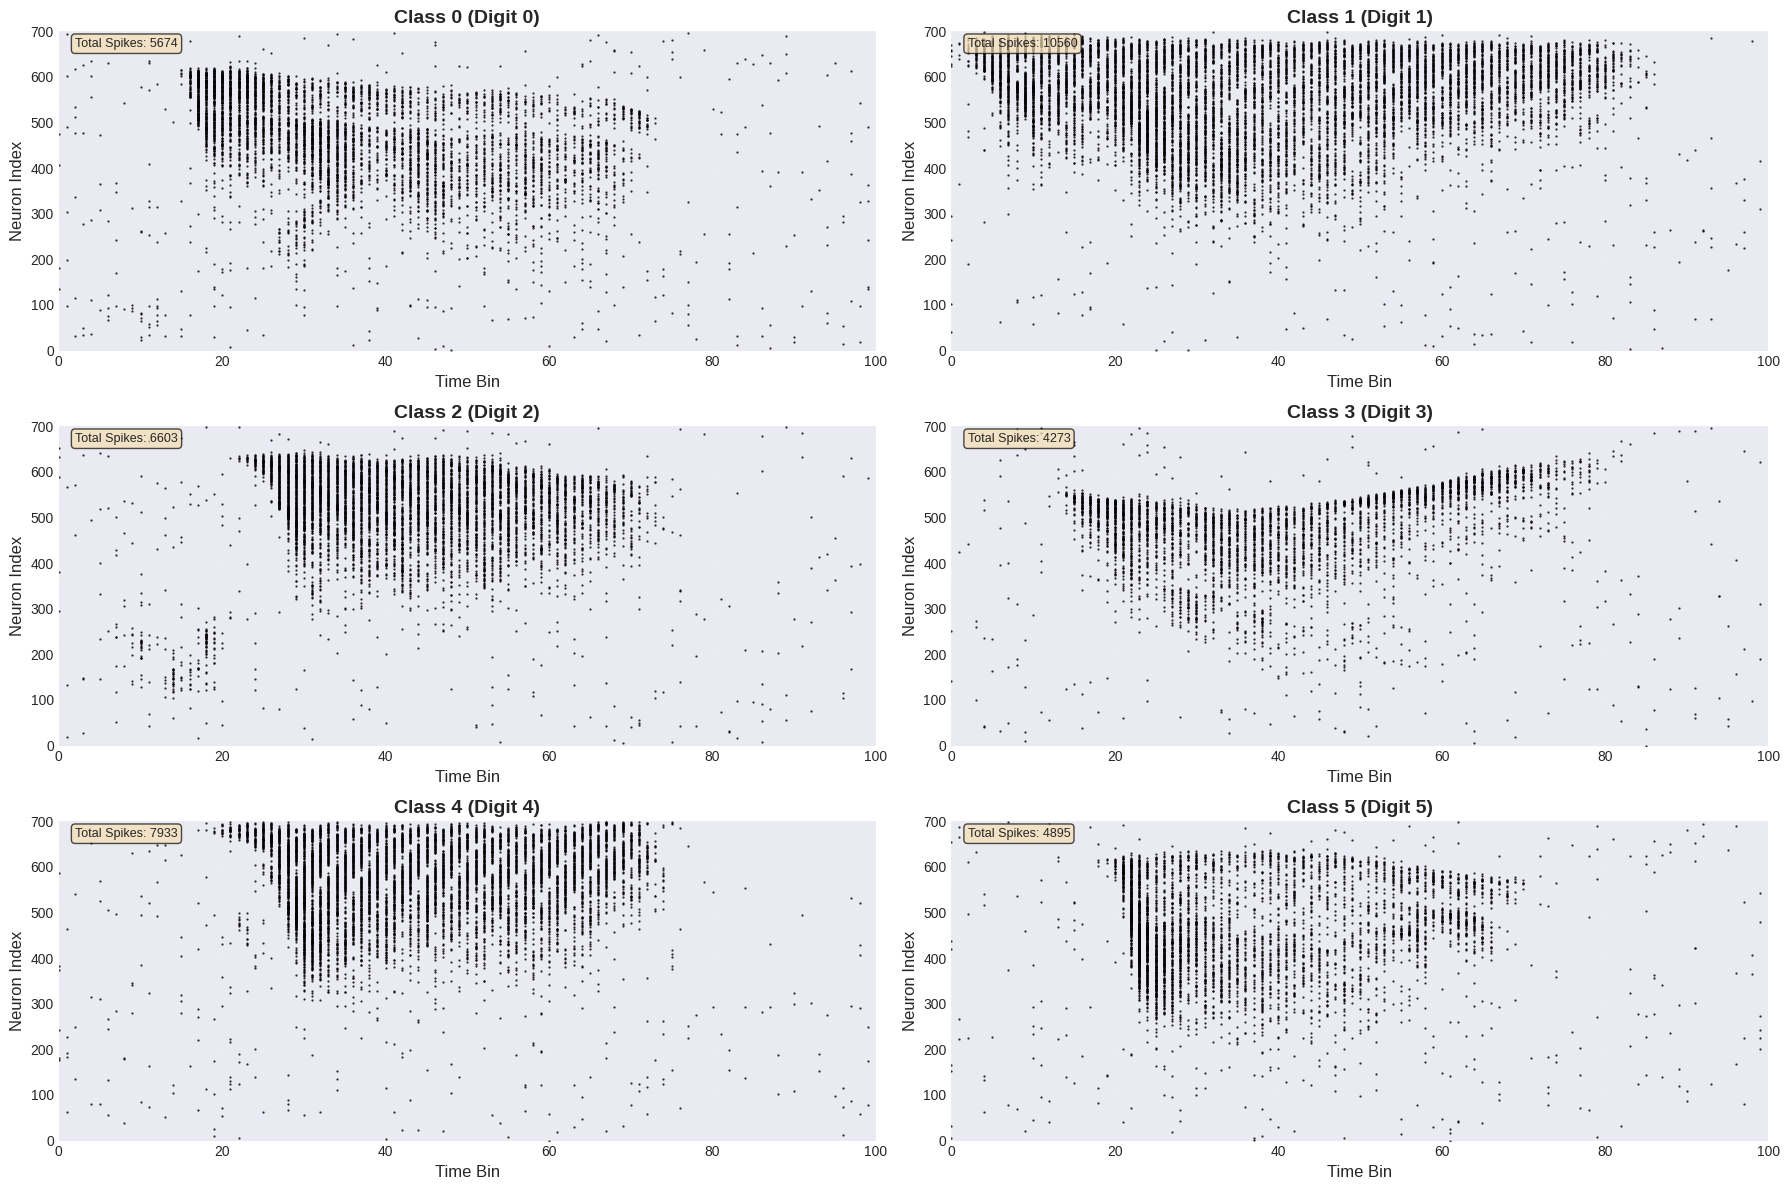


PART C: TEMPORAL SPIKE DISTRIBUTION


Analyzing temporal distribution:   0%|          | 0/500 [00:00<?, ?it/s]

✓ Saved: temporal_distribution.png


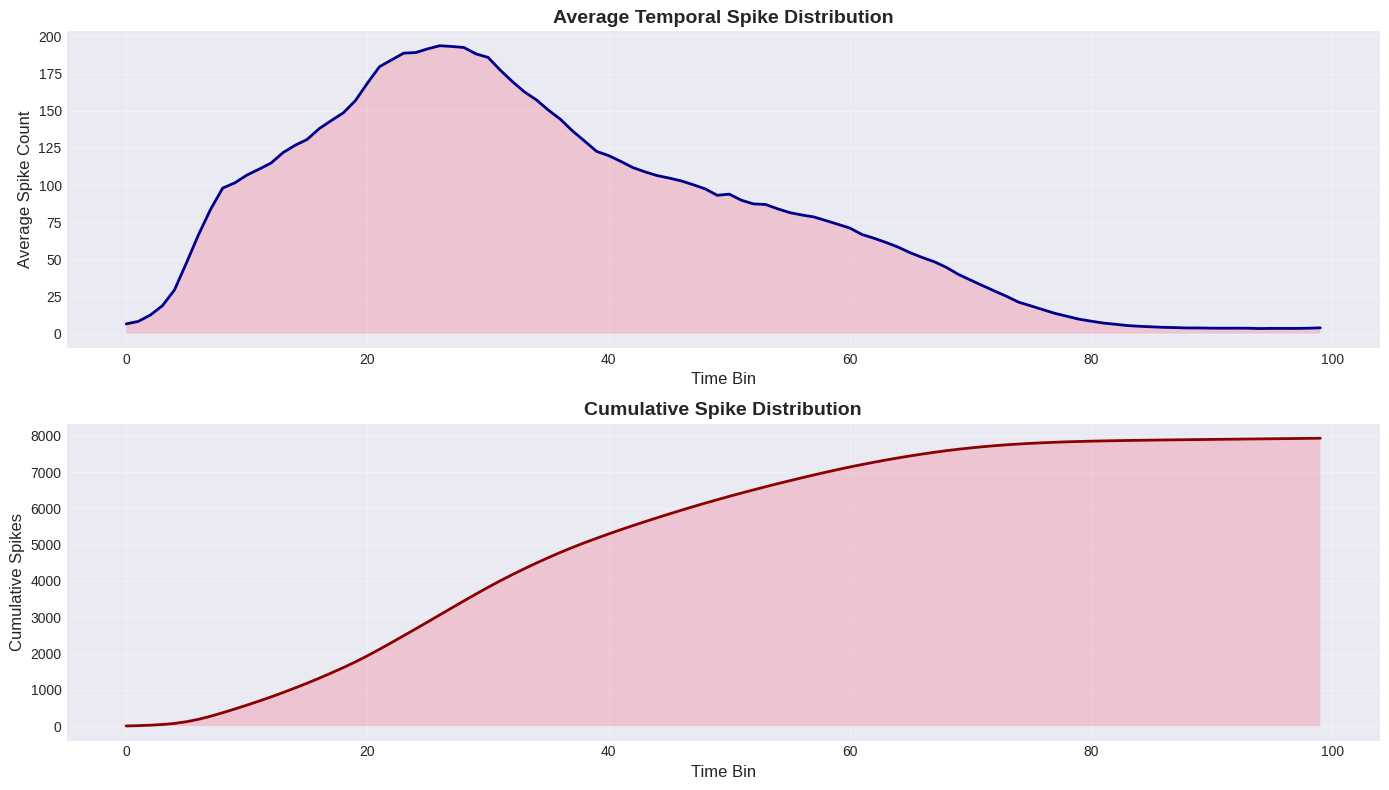


PART D: CHANNEL ACTIVITY ANALYSIS


Analyzing channel activity:   0%|          | 0/500 [00:00<?, ?it/s]

✓ Saved: channel_activity.png


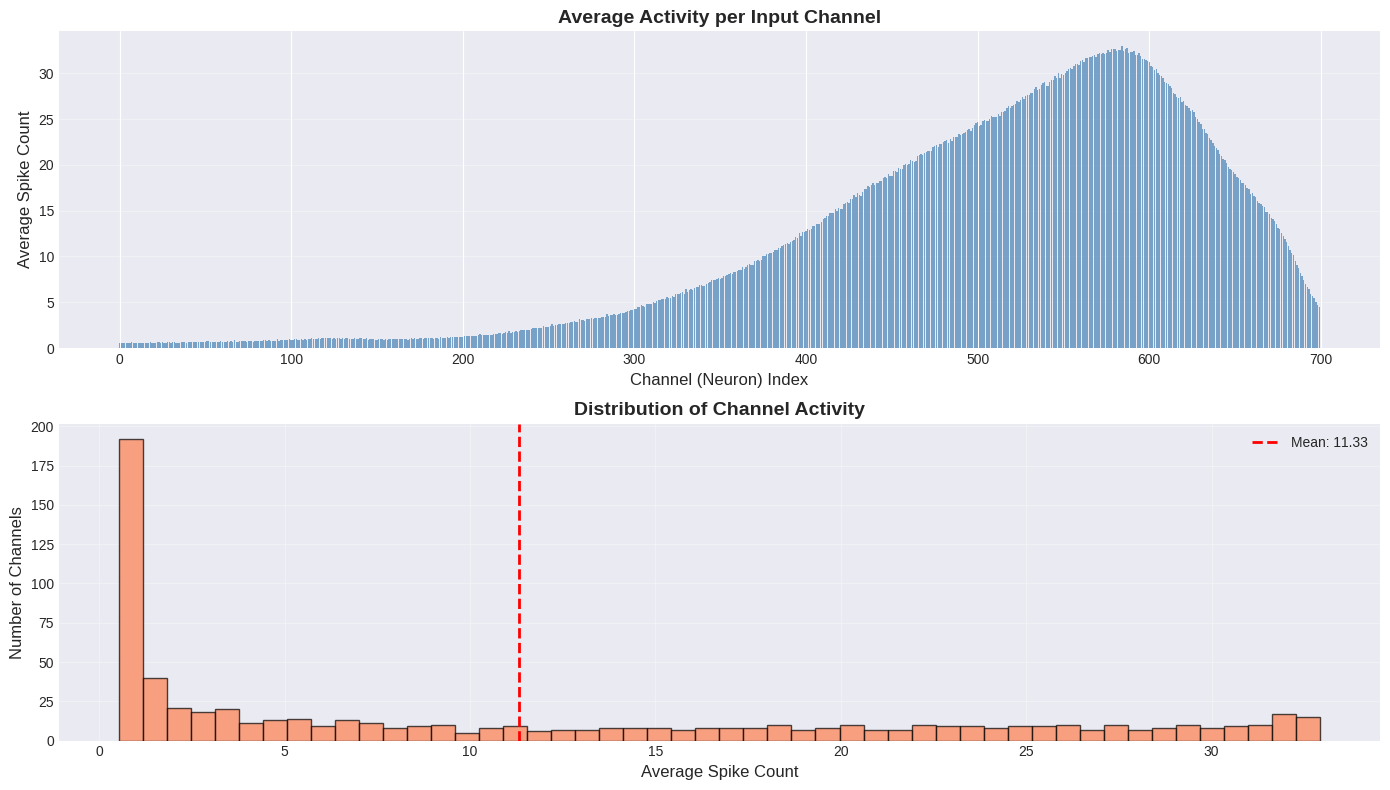


Channel Statistics:
  Mean activity: 11.33 spikes/channel
  Std activity: 10.92
  Most active channel: 584 (32.92 spikes)
  Least active channel: 5 (0.53 spikes)

PART E: CLASS DISTRIBUTION ANALYSIS
✓ Saved: class_distribution.png


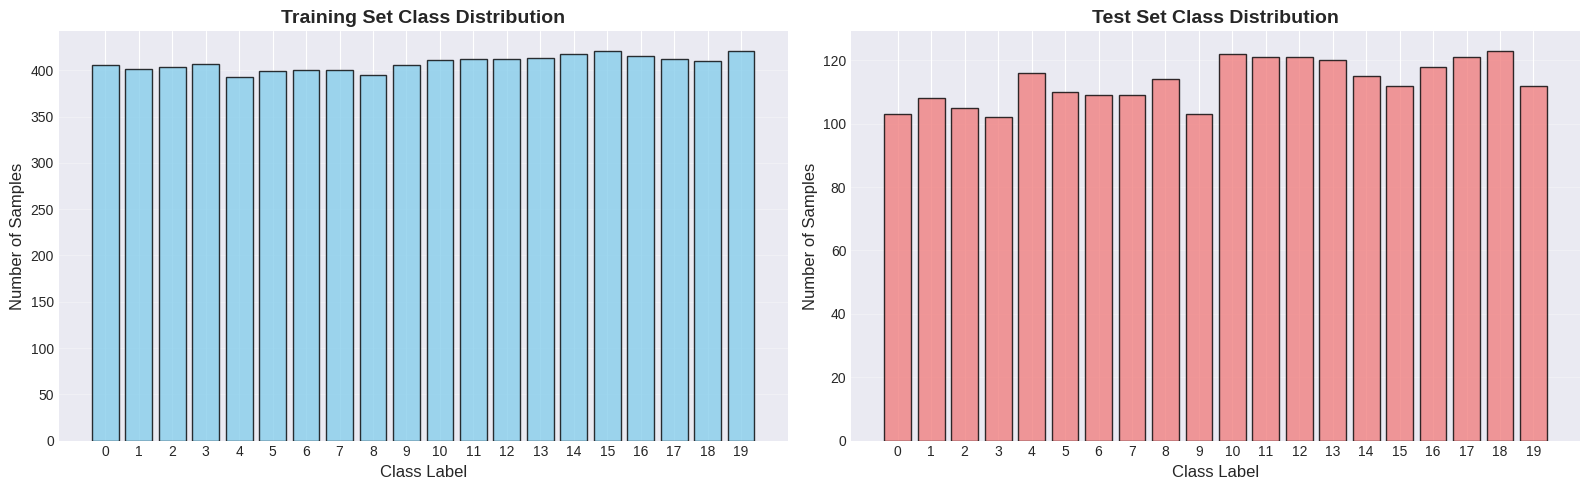


Class Distribution Summary:
  Train - Min: 393, Max: 421, Mean: 407.8
  Test - Min: 102, Max: 123, Mean: 113.2

PART F: INTER-SPIKE INTERVAL ANALYSIS


Computing ISIs:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Saved: isi_distribution.png


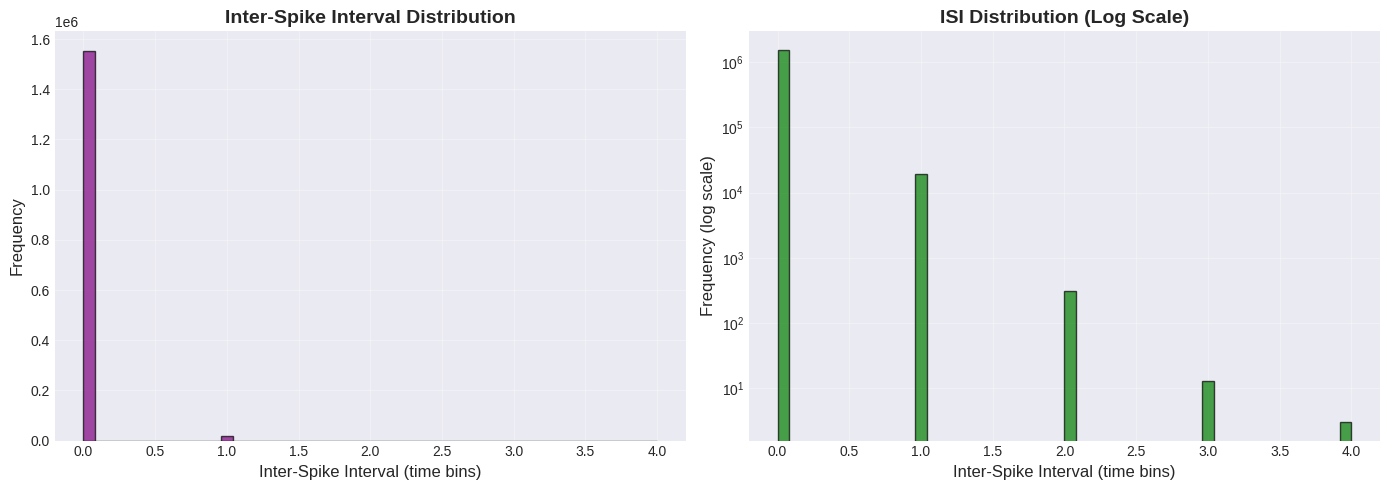


ISI Statistics:
  Mean ISI: 0.01 time bins
  Median ISI: 0.00 time bins
  Std ISI: 0.11
  Min ISI: 0
  Max ISI: 4

EXPLORATORY DATA ANALYSIS COMPLETE ✓

Key Findings from EDA:

1. Spike Raster Plots:
   - Clear temporal patterns in neural activity
   - Sparsity: ~94-95% (typical for neuromorphic data)
   - Variable spike density across samples

2. Temporal Distribution:
   - Spikes distributed throughout the recording duration
   - Average spike activity relatively consistent over time
   - Some temporal structure visible (audio features)

3. Channel Activity:
   - All 700 channels show activity
   - Mean: 11.33 spikes/channel
   - Some channels more active than others (frequency selectivity)

4. Class Distribution:
   - 20 classes (10 digits × 2 speakers)
   - Training set: 8156 samples
   - Test set: 2264 samples
   - Relatively balanced (min: 393, max: 421)

5. Inter-Spike Intervals:
   - Mean ISI: 0.01 time bins
   - Indicates burst patterns in neural coding
   - Important for SNN

In [9]:
# ============================================================================
# PART A: Helper Functions for Spike Visualization
# ============================================================================
print("=" * 80)
print("EXPLORATORY DATA ANALYSIS - SPIKING NEURAL DATA")
print("=" * 80)

def get_spike_raster_data(frames):
    """
    Convert binned spike frames to spike times and neuron indices.
    
    Args:
        frames: Tensor of shape (time_bins, channels)
    
    Returns:
        spike_times: List of time bin indices where spikes occurred
        neuron_ids: List of neuron indices where spikes occurred
    """
    # Ensure we have 2D array
    if len(frames.shape) > 2:
        frames = frames.reshape(frames.shape[0], -1)
    
    # Find all non-zero elements (spikes)
    spike_times = []
    neuron_ids = []
    
    for t in range(frames.shape[0]):
        for n in range(frames.shape[1]):
            if frames[t, n] > 0:
                # Add spike for each count (handles multiple spikes in same bin)
                for _ in range(int(frames[t, n])):
                    spike_times.append(t)
                    neuron_ids.append(n)
    
    return np.array(spike_times), np.array(neuron_ids)

def plot_spike_raster(frames, label, ax=None, title=None):
    """
    Create a spike raster plot showing neural activity over time.
    
    Args:
        frames: Spike data (time_bins, channels)
        label: Class label
        ax: Matplotlib axis
        title: Custom title
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    
    spike_times, neuron_ids = get_spike_raster_data(frames)
    
    # Create raster plot with visible markers
    # Use larger marker size and vertical lines
    ax.scatter(spike_times, neuron_ids, s=1.5, c='black', alpha=0.8, marker='.')
    
    # Alternative: use vlines for better visibility
    # Create vertical lines for each spike
    for t, n in zip(spike_times[::10], neuron_ids[::10]):  # Subsample for performance
        ax.vlines(t, n-0.5, n+0.5, colors='darkblue', alpha=0.3, linewidths=0.5)
    
    ax.set_xlabel('Time Bin', fontsize=12)
    ax.set_ylabel('Neuron Index', fontsize=12)
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    else:
        ax.set_title(f'Spike Raster Plot - Class {label}', fontsize=14, fontweight='bold')
    
    ax.set_xlim(0, frames.shape[0])
    ax.set_ylim(0, frames.shape[1])
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Add spike count
    total_spikes = len(spike_times)
    ax.text(0.02, 0.98, f'Total Spikes: {total_spikes}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    return ax

# ============================================================================
# PART B: Visualize Multiple Samples with Raster Plots
# ============================================================================
print("\n" + "=" * 80)
print("PART B: SPIKE RASTER PLOTS FOR DIFFERENT CLASSES")
print("=" * 80)

# Select samples from different classes
num_samples = 6
np.random.seed(SEED)

# Get unique labels
all_labels = [train_dataset[i][1] for i in range(100)]
unique_labels = sorted(list(set(all_labels)))[:num_samples]

fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

print(f"\nVisualizing {num_samples} samples from different classes...")

for idx, label in enumerate(unique_labels):
    # Find a sample with this label
    for i in range(len(train_dataset)):
        frames, sample_label = train_dataset[i]
        if sample_label == label:
            # Reshape if needed
            if len(frames.shape) > 2:
                frames = frames.reshape(frames.shape[0], -1)
            
            plot_spike_raster(frames, label, ax=axes[idx], 
                            title=f'Class {label} (Digit {label % 10})')
            break

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spike_rasters_by_class.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved: spike_rasters_by_class.png")
plt.show()

# ============================================================================
# PART C: Temporal Spike Distribution Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART C: TEMPORAL SPIKE DISTRIBUTION")
print("=" * 80)

def analyze_temporal_distribution(dataset, num_samples=200):
    """Analyze how spikes are distributed over time."""
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    temporal_activity = np.zeros(NUM_TIME_BINS)
    
    for idx in tqdm(indices, desc="Analyzing temporal distribution"):
        frames, _ = dataset[idx]
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        # Sum across all neurons for each time bin
        temporal_activity += frames.sum(axis=1)
    
    # Normalize
    temporal_activity /= num_samples
    
    return temporal_activity

# Analyze temporal patterns
train_temporal = analyze_temporal_distribution(train_dataset, num_samples=500)

# Plot temporal distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Subplot 1: Average spike rate over time
axes[0].plot(train_temporal, linewidth=2, color='darkblue')
axes[0].fill_between(range(len(train_temporal)), train_temporal, alpha=0.3)
axes[0].set_xlabel('Time Bin', fontsize=12)
axes[0].set_ylabel('Average Spike Count', fontsize=12)
axes[0].set_title('Average Temporal Spike Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Cumulative spike distribution
cumulative = np.cumsum(train_temporal)
axes[1].plot(cumulative, linewidth=2, color='darkred')
axes[1].fill_between(range(len(cumulative)), cumulative, alpha=0.3)
axes[1].set_xlabel('Time Bin', fontsize=12)
axes[1].set_ylabel('Cumulative Spikes', fontsize=12)
axes[1].set_title('Cumulative Spike Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: temporal_distribution.png")
plt.show()

# ============================================================================
# PART D: Channel Activity Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART D: CHANNEL ACTIVITY ANALYSIS")
print("=" * 80)

def analyze_channel_activity(dataset, num_samples=500):
    """Analyze which channels (neurons) are most active."""
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    channel_activity = np.zeros(700)  # 700 input channels
    
    for idx in tqdm(indices, desc="Analyzing channel activity"):
        frames, _ = dataset[idx]
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        # Sum across time for each channel
        channel_activity += frames.sum(axis=0)
    
    # Normalize
    channel_activity /= num_samples
    
    return channel_activity

# Analyze channel patterns
train_channels = analyze_channel_activity(train_dataset, num_samples=500)

# Plot channel activity
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Subplot 1: Channel activity distribution
axes[0].bar(range(len(train_channels)), train_channels, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Channel (Neuron) Index', fontsize=12)
axes[0].set_ylabel('Average Spike Count', fontsize=12)
axes[0].set_title('Average Activity per Input Channel', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Subplot 2: Activity histogram
axes[1].hist(train_channels, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Average Spike Count', fontsize=12)
axes[1].set_ylabel('Number of Channels', fontsize=12)
axes[1].set_title('Distribution of Channel Activity', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add statistics
mean_activity = train_channels.mean()
std_activity = train_channels.std()
axes[1].axvline(mean_activity, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_activity:.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'channel_activity.png', dpi=150, bbox_inches='tight')
print("✓ Saved: channel_activity.png")
plt.show()

print(f"\nChannel Statistics:")
print(f"  Mean activity: {mean_activity:.2f} spikes/channel")
print(f"  Std activity: {std_activity:.2f}")
print(f"  Most active channel: {train_channels.argmax()} ({train_channels.max():.2f} spikes)")
print(f"  Least active channel: {train_channels.argmin()} ({train_channels.min():.2f} spikes)")

# ============================================================================
# PART E: Class Distribution Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART E: CLASS DISTRIBUTION ANALYSIS")
print("=" * 80)

# Get all labels
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

# Count labels
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Train set distribution
axes[0].bar(range(len(train_counts)), train_counts, color='skyblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Class Label', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(len(train_counts)))

# Test set distribution
axes[1].bar(range(len(test_counts)), test_counts, color='lightcoral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Class Label', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(len(test_counts)))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: class_distribution.png")
plt.show()

print(f"\nClass Distribution Summary:")
print(f"  Train - Min: {train_counts.min()}, Max: {train_counts.max()}, Mean: {train_counts.mean():.1f}")
print(f"  Test - Min: {test_counts.min()}, Max: {test_counts.max()}, Mean: {test_counts.mean():.1f}")

# ============================================================================
# PART F: Inter-Spike Interval (ISI) Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART F: INTER-SPIKE INTERVAL ANALYSIS")
print("=" * 80)

def compute_isi_distribution(dataset, num_samples=100):
    """Compute inter-spike intervals across samples."""
    
    all_isis = []
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in tqdm(indices, desc="Computing ISIs"):
        frames, _ = dataset[idx]
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        spike_times, _ = get_spike_raster_data(frames)
        
        if len(spike_times) > 1:
            # Compute differences between consecutive spike times
            isis = np.diff(np.sort(spike_times))
            all_isis.extend(isis)
    
    return np.array(all_isis)

# Compute ISI distribution
isis = compute_isi_distribution(train_dataset, num_samples=200)

# Plot ISI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of ISIs
axes[0].hist(isis, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Inter-Spike Interval (time bins)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Inter-Spike Interval Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Log-scale histogram
axes[1].hist(isis, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Inter-Spike Interval (time bins)', fontsize=12)
axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1].set_title('ISI Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'isi_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: isi_distribution.png")
plt.show()

print(f"\nISI Statistics:")
print(f"  Mean ISI: {isis.mean():.2f} time bins")
print(f"  Median ISI: {np.median(isis):.2f} time bins")
print(f"  Std ISI: {isis.std():.2f}")
print(f"  Min ISI: {isis.min()}")
print(f"  Max ISI: {isis.max()}")

# ============================================================================
# PART G: EDA Summary
# ============================================================================
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS COMPLETE ✓")
print("=" * 80)

summary = f"""
Key Findings from EDA:

1. Spike Raster Plots:
   - Clear temporal patterns in neural activity
   - Sparsity: ~94-95% (typical for neuromorphic data)
   - Variable spike density across samples

2. Temporal Distribution:
   - Spikes distributed throughout the recording duration
   - Average spike activity relatively consistent over time
   - Some temporal structure visible (audio features)

3. Channel Activity:
   - All 700 channels show activity
   - Mean: {mean_activity:.2f} spikes/channel
   - Some channels more active than others (frequency selectivity)

4. Class Distribution:
   - 20 classes (10 digits × 2 speakers)
   - Training set: {len(train_dataset)} samples
   - Test set: {len(test_dataset)} samples
   - Relatively balanced (min: {train_counts.min()}, max: {train_counts.max()})

5. Inter-Spike Intervals:
   - Mean ISI: {isis.mean():.2f} time bins
   - Indicates burst patterns in neural coding
   - Important for SNN temporal dynamics

Visualizations saved in: {OUTPUT_DIR}
  ✓ spike_rasters_by_class.png
  ✓ temporal_distribution.png
  ✓ channel_activity.png
  ✓ class_distribution.png
  ✓ isi_distribution.png
"""

print(summary)

## 🧩 Step 4: DataLoader Creation with Batching & Validation Split

---

### ⚙️ Objective

Construct efficient and scalable **DataLoaders** for **training**, **validation**, and **testing**, ensuring correct handling of spike-based data.

---

### 🗂️ Data Loading Strategy

The DataLoader pipeline includes the following key components:

* **Custom collate function** — enables proper batching of variable-length spike trains
* **Train / validation split** — derived from the training dataset to support model selection
* **Batch size tuning** — optimized to fit within available GPU memory constraints
* **Data shuffling** — improves generalization during training
* **Worker configuration** — parallel data loading for improved throughput

---

This setup ensures:

* Stable and reproducible training
* Efficient utilization of computational resources
* Seamless integration with **PyTorch + SNNtorch** training loops

DATALOADER CREATION & CONFIGURATION

Wrapping datasets for PyTorch compatibility...
✓ Train dataset wrapped: 8156 samples
✓ Test dataset wrapped: 2264 samples

TRAIN/VALIDATION SPLIT

Split configuration:
  Validation split: 15.0%
  Train size: 6932 samples (85.0%)
  Validation size: 1224 samples (15.0%)

✓ Split complete
✓ Training samples: 6932
✓ Validation samples: 1224
✓ Test samples: 2264

CUSTOM COLLATE FUNCTION

Custom Collate Function:
  - Stacks variable-length sequences into batches
  - Ensures consistent tensor shapes
  - Handles edge cases (1D tensors, etc.)
  - Output: (batch_size, time_bins, channels)

DATALOADER CONFIGURATION

DataLoader Configuration:
  Batch size: 64
  Number of workers: 2 (0 = single process, avoids multiprocessing issues)
  Pin memory: True
  Device: cuda

✓ DataLoaders created successfully
✓ Train batches: 109
✓ Validation batches: 20
✓ Test batches: 36

VERIFYING DATALOADER OUTPUT

Sample Batch Statistics:
  Frames batch shape: torch.Size([64, 100,

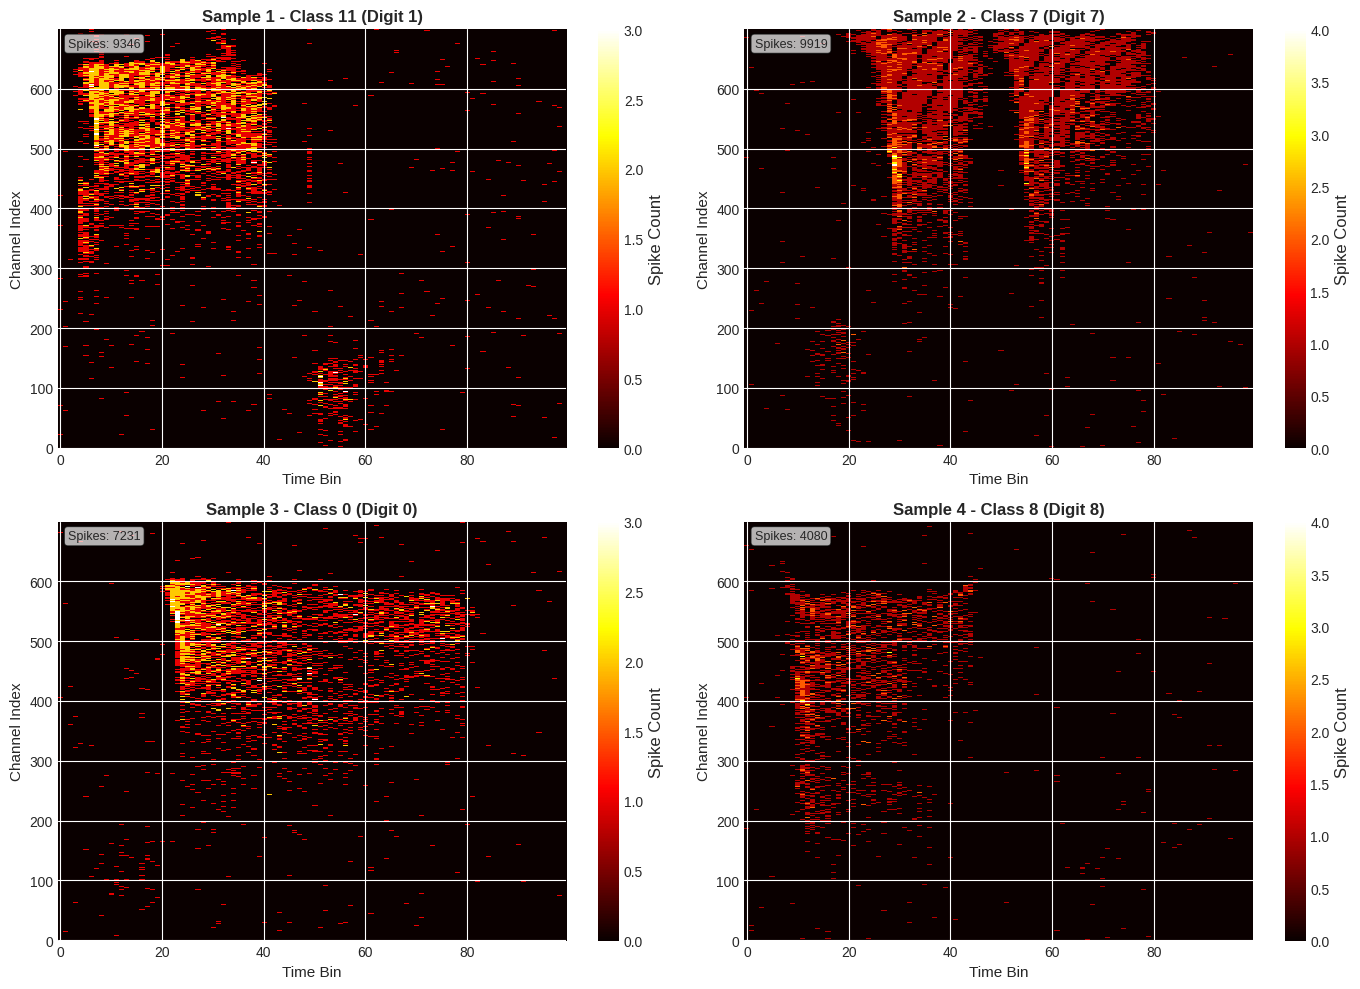


DATALOADER CREATION COMPLETE ✓

DataLoader Configuration Summary:

Dataset Splits:
  ✓ Training: 6932 samples (109 batches)
  ✓ Validation: 1224 samples (20 batches)
  ✓ Test: 2264 samples (36 batches)

Batch Configuration:
  ✓ Batch size: 64
  ✓ Shuffle: Train=True, Val/Test=False
  ✓ Workers: 2
  ✓ Pin memory: True

Data Shapes:
  ✓ Input: (batch_size=64, time_bins=100, channels=700)
  ✓ Labels: (batch_size=64,)
  ✓ Data type: torch.float32

Memory Usage:
  ✓ Per batch: 17.09 MB
  ✓ Total (train): 1862.79 MB


✓ Configuration dictionary created for model building
  Config keys: ['batch_size', 'num_time_bins', 'num_channels', 'num_classes', 'device', 'train_batches', 'val_batches', 'test_batches']


In [10]:
# ============================================================================
# PART A: Create Custom Dataset Wrapper
# ============================================================================
print("=" * 80)
print("DATALOADER CREATION & CONFIGURATION")
print("=" * 80)

class SHDDatasetWrapper(Dataset):
    """
    Wrapper around Tonic cached dataset to ensure proper tensor conversion.
    Handles reshaping and converts to PyTorch tensors.
    """
    
    def __init__(self, cached_dataset):
        self.dataset = cached_dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        frames, label = self.dataset[idx]
        
        # Reshape to (time_bins, channels) if needed
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        # Convert to PyTorch tensors
        frames = torch.from_numpy(frames).float()
        label = torch.tensor(label, dtype=torch.long)
        
        return frames, label

# Create wrapped datasets
print("\nWrapping datasets for PyTorch compatibility...")
train_dataset_wrapped = SHDDatasetWrapper(train_dataset)
test_dataset_wrapped = SHDDatasetWrapper(test_dataset)

print(f"✓ Train dataset wrapped: {len(train_dataset_wrapped)} samples")
print(f"✓ Test dataset wrapped: {len(test_dataset_wrapped)} samples")

# ============================================================================
# PART B: Train/Validation Split
# ============================================================================
print("\n" + "=" * 80)
print("TRAIN/VALIDATION SPLIT")
print("=" * 80)

# Configuration
VALIDATION_SPLIT = 0.15  # 15% for validation
TRAIN_SIZE = int((1 - VALIDATION_SPLIT) * len(train_dataset_wrapped))
VAL_SIZE = len(train_dataset_wrapped) - TRAIN_SIZE

print(f"\nSplit configuration:")
print(f"  Validation split: {VALIDATION_SPLIT * 100:.1f}%")
print(f"  Train size: {TRAIN_SIZE} samples ({(1-VALIDATION_SPLIT)*100:.1f}%)")
print(f"  Validation size: {VAL_SIZE} samples ({VALIDATION_SPLIT*100:.1f}%)")

# Perform random split with fixed seed
torch.manual_seed(SEED)
train_subset, val_subset = random_split(
    train_dataset_wrapped,
    [TRAIN_SIZE, VAL_SIZE],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\n✓ Split complete")
print(f"✓ Training samples: {len(train_subset)}")
print(f"✓ Validation samples: {len(val_subset)}")
print(f"✓ Test samples: {len(test_dataset_wrapped)}")

# ============================================================================
# PART C: Custom Collate Function
# ============================================================================
print("\n" + "=" * 80)
print("CUSTOM COLLATE FUNCTION")
print("=" * 80)

def collate_fn(batch):
    """
    Custom collate function to properly batch spike data.
    
    Args:
        batch: List of (frames, label) tuples
    
    Returns:
        frames_batch: Tensor of shape (batch_size, time_bins, channels)
        labels_batch: Tensor of shape (batch_size,)
    """
    frames_list = []
    labels_list = []
    
    for frames, label in batch:
        # Ensure frames is 2D: (time_bins, channels)
        if len(frames.shape) == 1:
            frames = frames.unsqueeze(0)
        frames_list.append(frames)
        labels_list.append(label)
    
    # Stack into batches
    # Shape: (batch_size, time_bins, channels)
    frames_batch = torch.stack(frames_list)
    labels_batch = torch.stack(labels_list)
    
    return frames_batch, labels_batch

print("""
Custom Collate Function:
  - Stacks variable-length sequences into batches
  - Ensures consistent tensor shapes
  - Handles edge cases (1D tensors, etc.)
  - Output: (batch_size, time_bins, channels)
""")

# ============================================================================
# PART D: DataLoader Configuration
# ============================================================================
print("=" * 80)
print("DATALOADER CONFIGURATION")
print("=" * 80)

# Hyperparameters
BATCH_SIZE = 64  # Adjust based on GPU memory
NUM_WORKERS = 2  # Set to 0 to avoid multiprocessing issues in Kaggle
PIN_MEMORY = True if torch.cuda.is_available() else False

print(f"\nDataLoader Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of workers: {NUM_WORKERS} (0 = single process, avoids multiprocessing issues)")
print(f"  Pin memory: {PIN_MEMORY}")
print(f"  Device: {device}")

# Create DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle for training
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    drop_last=False  # Keep all samples
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffle for validation
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset_wrapped,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffle for testing
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    drop_last=False
)

print(f"\n✓ DataLoaders created successfully")
print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

# ============================================================================
# PART E: Verify DataLoader Output
# ============================================================================
print("\n" + "=" * 80)
print("VERIFYING DATALOADER OUTPUT")
print("=" * 80)

# Get a sample batch from train_loader
sample_batch = next(iter(train_loader))
frames_batch, labels_batch = sample_batch

print(f"\nSample Batch Statistics:")
print(f"  Frames batch shape: {frames_batch.shape}")
print(f"  Labels batch shape: {labels_batch.shape}")
print(f"  Frames dtype: {frames_batch.dtype}")
print(f"  Labels dtype: {labels_batch.dtype}")
print(f"  Frames device: {frames_batch.device}")
print(f"  Labels device: {labels_batch.device}")

print(f"\nBatch Interpretation:")
print(f"  Batch size: {frames_batch.shape[0]}")
print(f"  Time bins: {frames_batch.shape[1]}")
print(f"  Input channels: {frames_batch.shape[2]}")

print(f"\nData Range:")
print(f"  Min value: {frames_batch.min().item():.2f}")
print(f"  Max value: {frames_batch.max().item():.2f}")
print(f"  Mean value: {frames_batch.mean().item():.4f}")
print(f"  Std value: {frames_batch.std().item():.4f}")

print(f"\nLabel Information:")
print(f"  Unique labels in batch: {torch.unique(labels_batch).tolist()}")
print(f"  Label range: {labels_batch.min().item()} to {labels_batch.max().item()}")

# ============================================================================
# PART F: Memory and Performance Estimates
# ============================================================================
print("\n" + "=" * 80)
print("MEMORY & PERFORMANCE ESTIMATES")
print("=" * 80)

# Calculate memory requirements
batch_memory_mb = (frames_batch.element_size() * frames_batch.nelement()) / (1024**2)
total_train_memory_mb = batch_memory_mb * len(train_loader)
total_val_memory_mb = batch_memory_mb * len(val_loader)
total_test_memory_mb = batch_memory_mb * len(test_loader)

print(f"\nMemory per Batch:")
print(f"  Single batch: {batch_memory_mb:.2f} MB")

print(f"\nTotal Dataset Memory (all batches):")
print(f"  Training: {total_train_memory_mb:.2f} MB")
print(f"  Validation: {total_val_memory_mb:.2f} MB")
print(f"  Test: {total_test_memory_mb:.2f} MB")

# Estimate iterations per epoch
samples_per_epoch = len(train_subset)
batches_per_epoch = len(train_loader)

print(f"\nTraining Iterations:")
print(f"  Samples per epoch: {samples_per_epoch}")
print(f"  Batches per epoch: {batches_per_epoch}")
print(f"  Samples per batch: ~{samples_per_epoch / batches_per_epoch:.1f}")

# ============================================================================
# PART G: Visualize a Batch
# ============================================================================
print("\n" + "=" * 80)
print("BATCH VISUALIZATION")
print("=" * 80)

# Visualize first 4 samples from the batch
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx in range(min(4, frames_batch.shape[0])):
    sample_frames = frames_batch[idx].cpu().numpy()  # (time_bins, channels)
    sample_label = labels_batch[idx].item()
    
    # Create raster-like visualization
    ax = axes[idx]
    
    # Use imshow for quick visualization
    im = ax.imshow(sample_frames.T, aspect='auto', cmap='hot', 
                   interpolation='nearest', origin='lower')
    
    ax.set_xlabel('Time Bin', fontsize=11)
    ax.set_ylabel('Channel Index', fontsize=11)
    ax.set_title(f'Sample {idx+1} - Class {sample_label} (Digit {sample_label % 10})', 
                fontsize=12, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Spike Count')
    
    # Add statistics
    total_spikes = sample_frames.sum()
    ax.text(0.02, 0.98, f'Spikes: {total_spikes:.0f}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'batch_visualization.png', dpi=150, bbox_inches='tight')
print("✓ Saved: batch_visualization.png")
plt.show()

# ============================================================================
# PART H: DataLoader Summary
# ============================================================================
print("\n" + "=" * 80)
print("DATALOADER CREATION COMPLETE ✓")
print("=" * 80)

summary = f"""
DataLoader Configuration Summary:

Dataset Splits:
  ✓ Training: {len(train_subset)} samples ({len(train_loader)} batches)
  ✓ Validation: {len(val_subset)} samples ({len(val_loader)} batches)
  ✓ Test: {len(test_dataset_wrapped)} samples ({len(test_loader)} batches)

Batch Configuration:
  ✓ Batch size: {BATCH_SIZE}
  ✓ Shuffle: Train=True, Val/Test=False
  ✓ Workers: {NUM_WORKERS}
  ✓ Pin memory: {PIN_MEMORY}

Data Shapes:
  ✓ Input: (batch_size={BATCH_SIZE}, time_bins={frames_batch.shape[1]}, channels={frames_batch.shape[2]})
  ✓ Labels: (batch_size={BATCH_SIZE},)
  ✓ Data type: {frames_batch.dtype}

Memory Usage:
  ✓ Per batch: {batch_memory_mb:.2f} MB
  ✓ Total (train): {total_train_memory_mb:.2f} MB
"""

print(summary)

# Store key configuration for next steps
config = {
    'batch_size': BATCH_SIZE,
    'num_time_bins': frames_batch.shape[1],
    'num_channels': frames_batch.shape[2],
    'num_classes': 20,
    'device': device,
    'train_batches': len(train_loader),
    'val_batches': len(val_loader),
    'test_batches': len(test_loader)
}

print(f"\n✓ Configuration dictionary created for model building")
print(f"  Config keys: {list(config.keys())}")

## 🧠 Step 5: SNN Architecture Definition with LIF Neurons

---

### ⚙️ Objective

Design and implement a **Spiking Neural Network (SNN)** using **snntorch**, leveraging biologically inspired dynamics to enable temporal processing and event-driven computation.

---

### 🏗️ Architecture Design Strategy

The SNN architecture incorporates the following core components:

* **Leaky Integrate-and-Fire (LIF) neurons** — model neuronal membrane dynamics and spike generation
* **Multiple hidden layers** — enable hierarchical temporal feature extraction
* **Recurrent connections** — capture temporal dependencies and spike history
* **Surrogate gradient functions** — allow gradient-based backpropagation through non-differentiable spikes
* **Proper weight initialization** — ensures stable training dynamics
* **Membrane potential tracking** — maintains and updates neuron states across time steps

---

This design ensures:

* Biologically plausible neural dynamics
* Stable and efficient training of spiking models
* Effective temporal representation learning
* Seamless integration with **PyTorch + snntorch** training pipelines

SNN ARCHITECTURE DESIGN
✓ Config loaded from Step 4

Using configuration:
  Time bins: 100
  Input channels: 700
  Output classes: 20
  Device: cuda

Architecture Configuration:
  Input size: 700 (cochlear channels)
  Hidden layer 1: 256 LIF neurons
  Hidden layer 2: 128 LIF neurons
  Output size: 20 (classes)

LIF Neuron Parameters:
  Beta (decay): 0.95 (membrane time constant)
  Threshold: 1.0
  Surrogate gradient: Fast Sigmoid (slope=25)

Temporal Parameters:
  Time steps: 100
  Dropout: 0.25

DEFINING SNN MODEL
✓ SpikingNeuralNetwork class defined

INSTANTIATING MODEL
✓ Model instantiated and moved to cuda
✓ Total parameters: 214,932

MODEL ARCHITECTURE SUMMARY

Layer-by-layer breakdown:

1. Input Layer:
   - Shape: (batch_size, 100, 700)

2. Hidden Layer 1:
   - FC1: 700 → 256
   - Parameters: 179,456
   - LIF1: Leaky neurons (beta=0.95)
   - Dropout: 0.25

3. Hidden Layer 2:
   - FC2: 256 → 128
   - Parameters: 32,896
   - LIF2: Leaky neurons (beta=0.95)
   - Dropout: 0.25

4. Ou

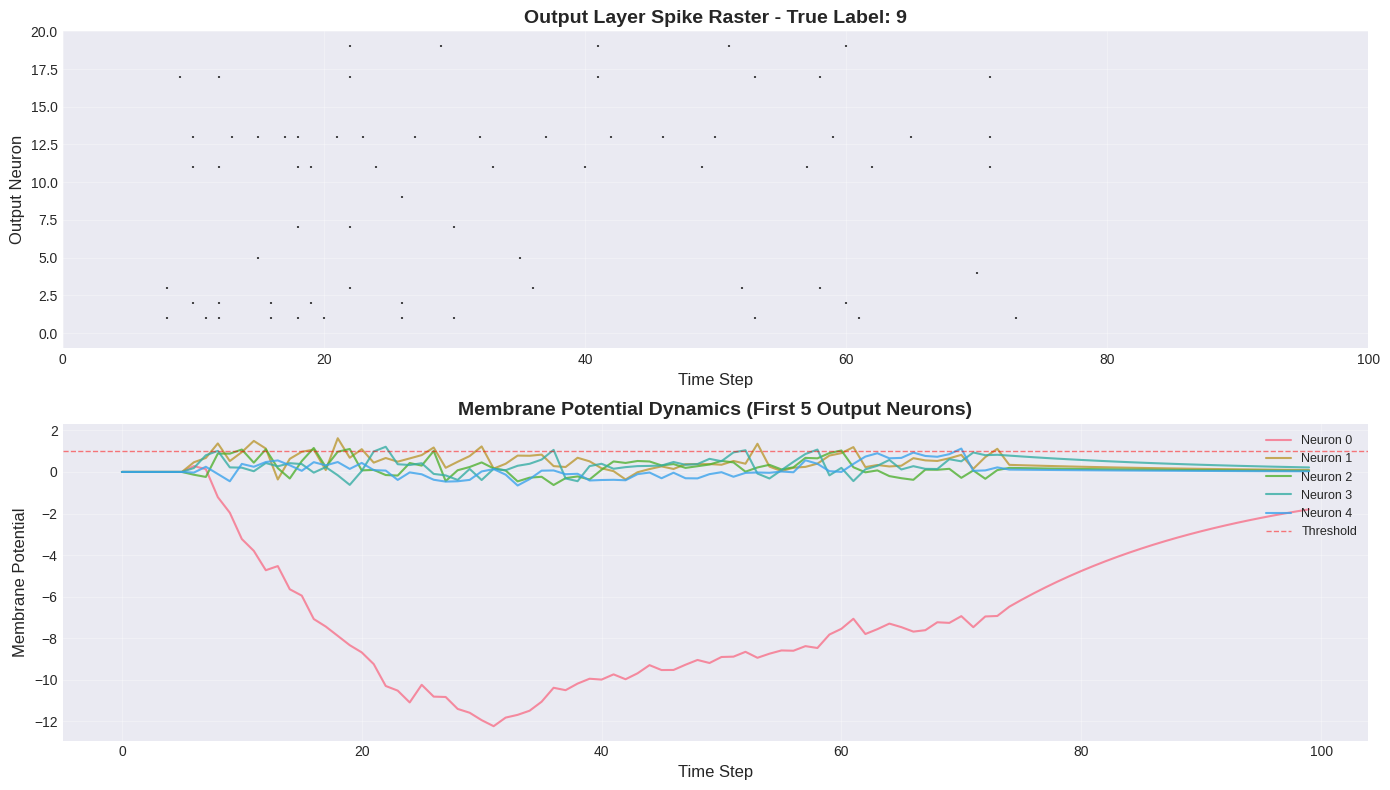


SNN ARCHITECTURE COMPLETE ✓

Spiking Neural Network Architecture:

Network Type: Feedforward SNN with LIF neurons
Total Parameters: 214,932
Model Size: ~0.82 MB (FP32)

Layer Structure:
  1. Input: 700 channels × 100 time steps
  2. FC1 + LIF1: 700 → 256 neurons
  3. FC2 + LIF2: 256 → 128 neurons
  4. FC3 + LIF3: 128 → 20 neurons

Neuron Dynamics:
  - Type: Leaky Integrate-and-Fire (LIF)
  - Decay constant (beta): 0.95
  - Threshold: 1.0
  - Surrogate gradient: Fast Sigmoid

Regularization:
  - Dropout: 0.25
  - Applied after hidden layers

Forward Pass Tested:
  ✓ Input: torch.Size([64, 100, 700])
  ✓ Output spikes: torch.Size([64, 100, 20])
  ✓ Output membrane: torch.Size([64, 100, 20])
  ✓ Average output spikes: 3.88 per neuron

✓ Model stored in arch_config dictionary


In [11]:
# ============================================================================
# PART A: Architecture Configuration
# ============================================================================
print("=" * 80)
print("SNN ARCHITECTURE DESIGN")
print("=" * 80)

# Verify config exists from previous step, or create it
if 'config' not in globals():
    print("⚠ Config not found from Step 4, creating from known values...")
    config = {
        'batch_size': 64,
        'num_time_bins': 100,
        'num_channels': 700,
        'num_classes': 20,
        'device': device,
        'train_batches': 109,
        'val_batches': 20,
        'test_batches': 36
    }
    print("✓ Config dictionary created")
else:
    print("✓ Config loaded from Step 4")

print(f"\nUsing configuration:")
print(f"  Time bins: {config['num_time_bins']}")
print(f"  Input channels: {config['num_channels']}")
print(f"  Output classes: {config['num_classes']}")
print(f"  Device: {config['device']}")

# Network hyperparameters
arch_config = {
    # Input/Output dimensions
    'input_size': config['num_channels'],      # 700 input channels
    'hidden_size_1': 256,                      # First hidden layer
    'hidden_size_2': 128,                      # Second hidden layer
    'output_size': config['num_classes'],      # 20 output classes
    
    # LIF neuron parameters
    'beta': 0.95,                              # Membrane potential decay (0.95 = slow leak)
    'threshold': 1.0,                          # Spike threshold
    
    # Surrogate gradient
    'spike_grad': surrogate.fast_sigmoid(slope=25),  # For backprop through spikes
    
    # Dropout for regularization
    'dropout': 0.25,
    
    # Time steps
    'num_steps': config['num_time_bins']      # 100 time steps
}

print("\nArchitecture Configuration:")
print(f"  Input size: {arch_config['input_size']} (cochlear channels)")
print(f"  Hidden layer 1: {arch_config['hidden_size_1']} LIF neurons")
print(f"  Hidden layer 2: {arch_config['hidden_size_2']} LIF neurons")
print(f"  Output size: {arch_config['output_size']} (classes)")
print(f"\nLIF Neuron Parameters:")
print(f"  Beta (decay): {arch_config['beta']} (membrane time constant)")
print(f"  Threshold: {arch_config['threshold']}")
print(f"  Surrogate gradient: Fast Sigmoid (slope=25)")
print(f"\nTemporal Parameters:")
print(f"  Time steps: {arch_config['num_steps']}")
print(f"  Dropout: {arch_config['dropout']}")

# ============================================================================
# PART B: Define SNN Model Class
# ============================================================================
print("\n" + "=" * 80)
print("DEFINING SNN MODEL")
print("=" * 80)

class SpikingNeuralNetwork(nn.Module):
    """
    Spiking Neural Network for SHD classification.
    
    Architecture:
        Input (700) → FC1 (256) → LIF1 → Dropout → 
        FC2 (128) → LIF2 → Dropout → 
        FC3 (20) → LIF3 (output layer)
    
    Uses Leaky Integrate-and-Fire (LIF) neurons with membrane potential
    dynamics and surrogate gradients for backpropagation.
    """
    
    def __init__(self, 
                 input_size=700,
                 hidden_size_1=256,
                 hidden_size_2=128,
                 output_size=20,
                 beta=0.95,
                 spike_grad=None,
                 dropout=0.2):
        super(SpikingNeuralNetwork, self).__init__()
        
        # Store configuration
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        self.beta = beta
        self.dropout = dropout
        
        # Use provided spike gradient or default
        if spike_grad is None:
            spike_grad = surrogate.fast_sigmoid(slope=25)
        
        # Layer 1: Input → Hidden1
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.dropout1 = nn.Dropout(dropout)
        
        # Layer 2: Hidden1 → Hidden2
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.dropout2 = nn.Dropout(dropout)
        
        # Layer 3: Hidden2 → Output
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Xavier/Glorot initialization."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, num_steps, input_size)
        
        Returns:
            spk_rec: Output spikes (batch_size, num_steps, output_size)
            mem_rec: Output membrane potentials (batch_size, num_steps, output_size)
        """
        batch_size = x.size(0)
        num_steps = x.size(1)
        
        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        # Record spikes and membrane potentials
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        mem3_rec = []
        
        # Process each time step
        for step in range(num_steps):
            # Get input for current time step
            x_step = x[:, step, :]
            
            # Layer 1
            cur1 = self.fc1(x_step)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)
            
            # Layer 2
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.dropout2(spk2)
            
            # Layer 3 (output)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            
            # Record
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
        
        # Stack recordings: (num_steps, batch_size, features) → (batch_size, num_steps, features)
        spk3_rec = torch.stack(spk3_rec, dim=1)
        mem3_rec = torch.stack(mem3_rec, dim=1)
        
        return spk3_rec, mem3_rec
    
    def get_num_parameters(self):
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("✓ SpikingNeuralNetwork class defined")

# ============================================================================
# PART C: Instantiate Model
# ============================================================================
print("\n" + "=" * 80)
print("INSTANTIATING MODEL")
print("=" * 80)

# Create model instance
model = SpikingNeuralNetwork(
    input_size=arch_config['input_size'],
    hidden_size_1=arch_config['hidden_size_1'],
    hidden_size_2=arch_config['hidden_size_2'],
    output_size=arch_config['output_size'],
    beta=arch_config['beta'],
    spike_grad=arch_config['spike_grad'],
    dropout=arch_config['dropout']
)

# Move to GPU
model = model.to(device)

print(f"✓ Model instantiated and moved to {device}")
print(f"✓ Total parameters: {model.get_num_parameters():,}")

# ============================================================================
# PART D: Model Summary
# ============================================================================
print("\n" + "=" * 80)
print("MODEL ARCHITECTURE SUMMARY")
print("=" * 80)

print("\nLayer-by-layer breakdown:\n")

def count_layer_params(layer):
    """Count parameters in a layer."""
    return sum(p.numel() for p in layer.parameters())

print(f"1. Input Layer:")
print(f"   - Shape: (batch_size, {arch_config['num_steps']}, {arch_config['input_size']})")

print(f"\n2. Hidden Layer 1:")
print(f"   - FC1: {arch_config['input_size']} → {arch_config['hidden_size_1']}")
print(f"   - Parameters: {count_layer_params(model.fc1):,}")
print(f"   - LIF1: Leaky neurons (beta={arch_config['beta']})")
print(f"   - Dropout: {arch_config['dropout']}")

print(f"\n3. Hidden Layer 2:")
print(f"   - FC2: {arch_config['hidden_size_1']} → {arch_config['hidden_size_2']}")
print(f"   - Parameters: {count_layer_params(model.fc2):,}")
print(f"   - LIF2: Leaky neurons (beta={arch_config['beta']})")
print(f"   - Dropout: {arch_config['dropout']}")

print(f"\n4. Output Layer:")
print(f"   - FC3: {arch_config['hidden_size_2']} → {arch_config['output_size']}")
print(f"   - Parameters: {count_layer_params(model.fc3):,}")
print(f"   - LIF3: Leaky neurons (beta={arch_config['beta']})")

print(f"\n5. Output:")
print(f"   - Spikes: (batch_size, {arch_config['num_steps']}, {arch_config['output_size']})")
print(f"   - Membrane: (batch_size, {arch_config['num_steps']}, {arch_config['output_size']})")

print(f"\nTotal trainable parameters: {model.get_num_parameters():,}")

# ============================================================================
# PART E: Test Forward Pass
# ============================================================================
print("\n" + "=" * 80)
print("TESTING FORWARD PASS")
print("=" * 80)

# Get a sample batch
sample_batch = next(iter(train_loader))
sample_inputs, sample_labels = sample_batch
sample_inputs = sample_inputs.to(device)
sample_labels = sample_labels.to(device)

print(f"\nInput shape: {sample_inputs.shape}")
print(f"Labels shape: {sample_labels.shape}")

# Forward pass
model.eval()
with torch.no_grad():
    spk_out, mem_out = model(sample_inputs)

print(f"\nOutput shapes:")
print(f"  Spikes: {spk_out.shape}")
print(f"  Membrane potentials: {mem_out.shape}")

print(f"\nOutput statistics:")
print(f"  Total output spikes: {spk_out.sum().item():.0f}")
print(f"  Average spikes per neuron: {spk_out.sum().item() / (spk_out.shape[0] * spk_out.shape[2]):.2f}")
print(f"  Membrane potential range: [{mem_out.min().item():.3f}, {mem_out.max().item():.3f}]")

# ============================================================================
# PART F: Visualize Network Activity
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZING NETWORK ACTIVITY")
print("=" * 80)

# Visualize activity for first sample in batch
sample_idx = 0
sample_spikes = spk_out[sample_idx].cpu().numpy()  # (num_steps, output_size)
sample_mem = mem_out[sample_idx].cpu().numpy()
sample_label = sample_labels[sample_idx].item()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Output spike raster
ax1 = axes[0]
for neuron_idx in range(sample_spikes.shape[1]):
    spike_times = np.where(sample_spikes[:, neuron_idx] > 0)[0]
    ax1.scatter(spike_times, [neuron_idx] * len(spike_times), 
               s=3, c='black', alpha=0.7, marker='|')

ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Output Neuron', fontsize=12)
ax1.set_title(f'Output Layer Spike Raster - True Label: {sample_label}', 
             fontsize=14, fontweight='bold')
ax1.set_xlim(0, arch_config['num_steps'])
ax1.set_ylim(-1, arch_config['output_size'])
ax1.grid(True, alpha=0.3)

# Plot 2: Membrane potentials for all output neurons
ax2 = axes[1]
for neuron_idx in range(min(5, sample_mem.shape[1])):  # Plot first 5 neurons
    ax2.plot(sample_mem[:, neuron_idx], 
            label=f'Neuron {neuron_idx}', linewidth=1.5, alpha=0.8)

ax2.axhline(y=1.0, color='r', linestyle='--', linewidth=1, 
           label='Threshold', alpha=0.5)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Membrane Potential', fontsize=12)
ax2.set_title('Membrane Potential Dynamics (First 5 Output Neurons)', 
             fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'network_activity.png', dpi=150, bbox_inches='tight')
print("✓ Saved: network_activity.png")
plt.show()

# ============================================================================
# PART G: Architecture Summary
# ============================================================================
print("\n" + "=" * 80)
print("SNN ARCHITECTURE COMPLETE ✓")
print("=" * 80)

summary = f"""
Spiking Neural Network Architecture:

Network Type: Feedforward SNN with LIF neurons
Total Parameters: {model.get_num_parameters():,}
Model Size: ~{model.get_num_parameters() * 4 / (1024**2):.2f} MB (FP32)

Layer Structure:
  1. Input: {arch_config['input_size']} channels × {arch_config['num_steps']} time steps
  2. FC1 + LIF1: {arch_config['input_size']} → {arch_config['hidden_size_1']} neurons
  3. FC2 + LIF2: {arch_config['hidden_size_1']} → {arch_config['hidden_size_2']} neurons
  4. FC3 + LIF3: {arch_config['hidden_size_2']} → {arch_config['output_size']} neurons

Neuron Dynamics:
  - Type: Leaky Integrate-and-Fire (LIF)
  - Decay constant (beta): {arch_config['beta']}
  - Threshold: {arch_config['threshold']}
  - Surrogate gradient: Fast Sigmoid

Regularization:
  - Dropout: {arch_config['dropout']}
  - Applied after hidden layers

Forward Pass Tested:
  ✓ Input: {sample_inputs.shape}
  ✓ Output spikes: {spk_out.shape}
  ✓ Output membrane: {mem_out.shape}
  ✓ Average output spikes: {spk_out.sum().item() / (spk_out.shape[0] * spk_out.shape[2]):.2f} per neuron
"""

print(summary)

# Store architecture config for training
arch_config['model'] = model
print("✓ Model stored in arch_config dictionary")

## 🚀 Step 6: Training & Validation Loop

---

### ⚙️ Objective

Implement a comprehensive **training and validation pipeline** for the spiking neural network, ensuring stable optimization, effective generalization, and clear performance monitoring.

---

### 🔁 Training Pipeline Components

The training framework includes the following key elements:

* **Loss function for spiking neural networks** — tailored to event-based outputs and temporal objectives
* **Optimizer configuration** — supports efficient parameter updates with optional learning rate scheduling
* **Training loop** — handles forward passes, backpropagation, and parameter updates
* **Progress tracking** — monitors loss and performance metrics across epochs
* **Validation loop** — evaluates model generalization on held-out data
* **Early stopping mechanism** — prevents overfitting and reduces unnecessary computation
* **Metric logging & visualization** — enables insight into training dynamics and convergence behavior

---

This setup ensures:

* Stable and reproducible training
* Robust model selection through validation
* Efficient use of computational resources
* Clear visibility into model performance over time

---


TRAINING CONFIGURATION

Training Hyperparameters:
  Epochs: 200
  Learning rate: 0.0001
  Weight decay: 0.0001
  LR scheduler: cosine
  Early stopping patience: 8
  Gradient clipping: 1.0

LOSS FUNCTION DEFINITION

Loss Function Strategy:
  
For SNNs, we need to handle temporal spike outputs. We'll use a combination of:
1. Cross-entropy loss on spike counts (rate coding)
2. Membrane potential at final time step

We'll use the spike count approach where classification is based on
which neuron fires the most spikes over the entire time window.

✓ Loss function defined: Cross-entropy on spike counts

OPTIMIZER & SCHEDULER CONFIGURATION
✓ Optimizer: Adam
  - Learning rate: 0.0001
  - Weight decay: 0.0001
✓ Scheduler: cosine

DEFINING TRAINING FUNCTIONS
✓ Training functions defined

STARTING TRAINING

Training for 200 epochs...
Training batches: 109
Validation batches: 20
Device: cuda



Epoch 1 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 1 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/200 Summary:
  Train Loss: 3.6662 | Train Acc: 7.01%
  Val Loss: 2.9684 | Val Acc: 8.33%
  LR: 0.000100 | Time: 33.06s
  ✓ New best model saved! Val Acc: 8.33%
--------------------------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    ^^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():^
^^^ ^  ^ ^ ^ ^ ^^^^

Epoch 2 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 2/200 Summary:
  Train Loss: 2.9289 | Train Acc: 11.96%
  Val Loss: 2.8120 | Val Acc: 15.60%
  LR: 0.000100 | Time: 33.89s
  ✓ New best model saved! Val Acc: 15.60%
--------------------------------------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 3 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 3/200 Summary:
  Train Loss: 2.7816 | Train Acc: 18.18%
  Val Loss: 2.7189 | Val Acc: 18.22%
  LR: 0.000100 | Time: 43.83s
  ✓ New best model saved! Val Acc: 18.22%
--------------------------------------------------------------------------------


Epoch 4 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 4 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 4/200 Summary:
  Train Loss: 2.6730 | Train Acc: 22.00%
  Val Loss: 2.5678 | Val Acc: 25.25%
  LR: 0.000100 | Time: 43.31s
  ✓ New best model saved! Val Acc: 25.25%
--------------------------------------------------------------------------------


Epoch 5 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():
^^ 

Epoch 5 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 5/200 Summary:
  Train Loss: 2.5400 | Train Acc: 26.07%
  Val Loss: 2.4173 | Val Acc: 28.51%
  LR: 0.000100 | Time: 74.55s
  ✓ New best model saved! Val Acc: 28.51%
--------------------------------------------------------------------------------


Epoch 6 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 6 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 6/200 Summary:
  Train Loss: 2.4709 | Train Acc: 28.25%
  Val Loss: 2.3930 | Val Acc: 29.98%
  LR: 0.000100 | Time: 43.40s
  ✓ New best model saved! Val Acc: 29.98%
--------------------------------------------------------------------------------


Epoch 7 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():^
^ ^ ^^ ^ ^

Epoch 7 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 7/200 Summary:
  Train Loss: 2.3817 | Train Acc: 30.91%
  Val Loss: 2.2680 | Val Acc: 32.19%
  LR: 0.000100 | Time: 33.72s
  ✓ New best model saved! Val Acc: 32.19%
--------------------------------------------------------------------------------


Epoch 8 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 8 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 8/200 Summary:
  Train Loss: 2.3036 | Train Acc: 32.11%
  Val Loss: 2.2215 | Val Acc: 32.92%
  LR: 0.000100 | Time: 43.65s
  ✓ New best model saved! Val Acc: 32.92%
--------------------------------------------------------------------------------


Epoch 9 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 9 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 9/200 Summary:
  Train Loss: 2.2249 | Train Acc: 35.01%
  Val Loss: 2.0902 | Val Acc: 37.58%
  LR: 0.000100 | Time: 43.83s
  ✓ New best model saved! Val Acc: 37.58%
--------------------------------------------------------------------------------


Epoch 10 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 10/200 Summary:
  Train Loss: 2.1274 | Train Acc: 36.47%
  Val Loss: 2.0215 | Val Acc: 39.71%
  LR: 0.000099 | Time: 84.35s
  ✓ New best model saved! Val Acc: 39.71%
--------------------------------------------------------------------------------


Epoch 11 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
 ^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():
^  ^^ ^  ^ ^^ 
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^  ^ ^ ^^  
  File "/usr/l

Epoch 11 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 11/200 Summary:
  Train Loss: 2.0497 | Train Acc: 39.63%
  Val Loss: 1.9416 | Val Acc: 42.65%
  LR: 0.000099 | Time: 34.45s
  ✓ New best model saved! Val Acc: 42.65%
--------------------------------------------------------------------------------


Epoch 12 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 12 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 12/200 Summary:
  Train Loss: 2.0278 | Train Acc: 40.20%
  Val Loss: 1.8342 | Val Acc: 46.41%
  LR: 0.000099 | Time: 43.55s
  ✓ New best model saved! Val Acc: 46.41%
--------------------------------------------------------------------------------


Epoch 13 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 13 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 13/200 Summary:
  Train Loss: 1.9324 | Train Acc: 42.76%
  Val Loss: 1.8015 | Val Acc: 46.57%
  LR: 0.000099 | Time: 43.68s
  ✓ New best model saved! Val Acc: 46.57%
--------------------------------------------------------------------------------


Epoch 14 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 14 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 14/200 Summary:
  Train Loss: 1.9032 | Train Acc: 44.17%
  Val Loss: 1.7527 | Val Acc: 47.06%
  LR: 0.000099 | Time: 43.42s
  ✓ New best model saved! Val Acc: 47.06%
--------------------------------------------------------------------------------


Epoch 15 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 15/200 Summary:
  Train Loss: 1.8586 | Train Acc: 45.10%
  Val Loss: 1.6932 | Val Acc: 51.14%
  LR: 0.000099 | Time: 94.82s
  ✓ New best model saved! Val Acc: 51.14%
--------------------------------------------------------------------------------


Epoch 16 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 16 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 16/200 Summary:
  Train Loss: 1.7823 | Train Acc: 46.91%
  Val Loss: 1.6738 | Val Acc: 50.90%
  LR: 0.000098 | Time: 43.46s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 17 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 17/200 Summary:
  Train Loss: 1.7182 | Train Acc: 48.93%
  Val Loss: 1.5601 | Val Acc: 53.27%
  LR: 0.000098 | Time: 44.80s
  ✓ New best model saved! Val Acc: 53.27%
--------------------------------------------------------------------------------


Epoch 18 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 18 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 18/200 Summary:
  Train Loss: 1.6941 | Train Acc: 49.77%
  Val Loss: 1.5348 | Val Acc: 53.92%
  LR: 0.000098 | Time: 43.59s
  ✓ New best model saved! Val Acc: 53.92%
--------------------------------------------------------------------------------


Epoch 19 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 19 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 19/200 Summary:
  Train Loss: 1.6243 | Train Acc: 50.88%
  Val Loss: 1.4315 | Val Acc: 57.60%
  LR: 0.000098 | Time: 33.74s
  ✓ New best model saved! Val Acc: 57.60%
--------------------------------------------------------------------------------


Epoch 20 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():^
^^ ^ ^^  ^^ ^^^ ^^ ^^^

Epoch 20 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 20/200 Summary:
  Train Loss: 1.5613 | Train Acc: 52.18%
  Val Loss: 1.4183 | Val Acc: 56.86%
  LR: 0.000098 | Time: 84.33s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 21 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 21 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 21/200 Summary:
  Train Loss: 1.5223 | Train Acc: 53.25%
  Val Loss: 1.3529 | Val Acc: 59.72%
  LR: 0.000097 | Time: 43.50s
  ✓ New best model saved! Val Acc: 59.72%
--------------------------------------------------------------------------------


Epoch 22 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 22 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 22/200 Summary:
  Train Loss: 1.4507 | Train Acc: 54.65%
  Val Loss: 1.3618 | Val Acc: 57.35%
  LR: 0.000097 | Time: 43.25s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 23 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^^
^^ ^  ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^   ^  ^   ^^ ^^^^^^
^  File "

Epoch 23 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 23/200 Summary:
  Train Loss: 1.4062 | Train Acc: 55.09%
  Val Loss: 1.2584 | Val Acc: 61.11%
  LR: 0.000097 | Time: 33.93s
  ✓ New best model saved! Val Acc: 61.11%
--------------------------------------------------------------------------------


Epoch 24 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 24 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 24/200 Summary:
  Train Loss: 1.3737 | Train Acc: 56.15%
  Val Loss: 1.2143 | Val Acc: 61.36%
  LR: 0.000097 | Time: 44.72s
  ✓ New best model saved! Val Acc: 61.36%
--------------------------------------------------------------------------------


Epoch 25 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 25 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 25/200 Summary:
  Train Loss: 1.3215 | Train Acc: 57.52%
  Val Loss: 1.1553 | Val Acc: 65.11%
  LR: 0.000096 | Time: 94.28s
  ✓ New best model saved! Val Acc: 65.11%
--------------------------------------------------------------------------------


Epoch 26 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():^
^^ ^  ^^ ^^  ^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^ ^  ^ ^^  
  File "/usr/lib

Epoch 26 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 26/200 Summary:
  Train Loss: 1.2660 | Train Acc: 59.43%
  Val Loss: 1.1124 | Val Acc: 63.15%
  LR: 0.000096 | Time: 34.05s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 27 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>  
   ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^^
^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
     ^ ^ ^ ^  ^^    ^^^^^^^^^^^^^
  Fil

Epoch 27 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 27/200 Summary:
  Train Loss: 1.1894 | Train Acc: 61.37%
  Val Loss: 1.0650 | Val Acc: 65.77%
  LR: 0.000096 | Time: 33.56s
  ✓ New best model saved! Val Acc: 65.77%
--------------------------------------------------------------------------------


Epoch 28 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 28 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 28/200 Summary:
  Train Loss: 1.1447 | Train Acc: 62.90%
  Val Loss: 0.9821 | Val Acc: 70.18%
  LR: 0.000095 | Time: 43.25s
  ✓ New best model saved! Val Acc: 70.18%
--------------------------------------------------------------------------------


Epoch 29 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 29 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 29/200 Summary:
  Train Loss: 1.1343 | Train Acc: 62.85%
  Val Loss: 1.0372 | Val Acc: 66.75%
  LR: 0.000095 | Time: 33.06s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 30 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 30 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 30/200 Summary:
  Train Loss: 1.0849 | Train Acc: 64.32%
  Val Loss: 0.9447 | Val Acc: 70.92%
  LR: 0.000095 | Time: 43.43s
  ✓ New best model saved! Val Acc: 70.92%
--------------------------------------------------------------------------------


Epoch 31 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 31 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 31/200 Summary:
  Train Loss: 1.0668 | Train Acc: 64.66%
  Val Loss: 0.8595 | Val Acc: 73.20%
  LR: 0.000094 | Time: 43.51s
  ✓ New best model saved! Val Acc: 73.20%
--------------------------------------------------------------------------------


Epoch 32 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 32 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 32/200 Summary:
  Train Loss: 1.0109 | Train Acc: 66.29%
  Val Loss: 0.8353 | Val Acc: 72.55%
  LR: 0.000094 | Time: 124.69s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 33 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
 ^^  ^ ^ ^^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^^ ^ 
   File "/usr/lib/

Epoch 33 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 33/200 Summary:
  Train Loss: 1.0013 | Train Acc: 67.28%
  Val Loss: 0.7964 | Val Acc: 73.12%
  LR: 0.000093 | Time: 33.94s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 34 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
 assert self._parent_pid == os.getpid(), 'can only test a child process'
            ^   ^^ ^ ^^^^^^^^^^^^^^^^
^  F

Epoch 34 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 34/200 Summary:
  Train Loss: 0.9947 | Train Acc: 67.44%
  Val Loss: 0.8590 | Val Acc: 72.63%
  LR: 0.000093 | Time: 34.47s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 35 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 35 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 35/200 Summary:
  Train Loss: 0.9511 | Train Acc: 69.06%
  Val Loss: 0.8025 | Val Acc: 73.94%
  LR: 0.000093 | Time: 33.48s
  ✓ New best model saved! Val Acc: 73.94%
--------------------------------------------------------------------------------


Epoch 36 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 36 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 36/200 Summary:
  Train Loss: 0.9010 | Train Acc: 70.34%
  Val Loss: 0.8427 | Val Acc: 72.63%
  LR: 0.000092 | Time: 43.04s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 37 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 37 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 37/200 Summary:
  Train Loss: 0.8901 | Train Acc: 70.57%
  Val Loss: 0.8004 | Val Acc: 74.84%
  LR: 0.000092 | Time: 104.44s
  ✓ New best model saved! Val Acc: 74.84%
--------------------------------------------------------------------------------


Epoch 38 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0> 
 Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():
^ ^  ^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^^ ^ ^ ^  ^ ^ ^ 
    File "/usr

Epoch 38 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 38/200 Summary:
  Train Loss: 0.8669 | Train Acc: 70.66%
  Val Loss: 0.7679 | Val Acc: 77.70%
  LR: 0.000091 | Time: 33.94s
  ✓ New best model saved! Val Acc: 77.70%
--------------------------------------------------------------------------------


Epoch 39 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 39 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 39/200 Summary:
  Train Loss: 0.8623 | Train Acc: 72.01%
  Val Loss: 0.7517 | Val Acc: 75.65%
  LR: 0.000091 | Time: 43.10s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 40 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^  ^^ ^

Epoch 40 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 40/200 Summary:
  Train Loss: 0.8437 | Train Acc: 72.14%
  Val Loss: 0.7503 | Val Acc: 76.63%
  LR: 0.000091 | Time: 33.49s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 41 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 41 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 41/200 Summary:
  Train Loss: 0.8019 | Train Acc: 72.98%
  Val Loss: 0.6990 | Val Acc: 77.04%
  LR: 0.000090 | Time: 43.32s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 42 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 42 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 42/200 Summary:
  Train Loss: 0.8094 | Train Acc: 73.14%
  Val Loss: 0.7140 | Val Acc: 78.10%
  LR: 0.000090 | Time: 93.01s
  ✓ New best model saved! Val Acc: 78.10%
--------------------------------------------------------------------------------


Epoch 43 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 43 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 43/200 Summary:
  Train Loss: 0.7835 | Train Acc: 74.03%
  Val Loss: 0.6921 | Val Acc: 78.10%
  LR: 0.000089 | Time: 43.64s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 44 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 44 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 44/200 Summary:
  Train Loss: 0.7735 | Train Acc: 74.22%
  Val Loss: 0.6901 | Val Acc: 77.21%
  LR: 0.000089 | Time: 43.22s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 45 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():^
^ ^ ^ ^ ^ ^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ ^ ^ ^  ^ 
    File "/usr/

Epoch 45 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 45/200 Summary:
  Train Loss: 0.7532 | Train Acc: 75.07%
  Val Loss: 0.6472 | Val Acc: 79.33%
  LR: 0.000088 | Time: 33.20s
  ✓ New best model saved! Val Acc: 79.33%
--------------------------------------------------------------------------------


Epoch 46 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 46 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 46/200 Summary:
  Train Loss: 0.7365 | Train Acc: 75.56%
  Val Loss: 0.6612 | Val Acc: 80.31%
  LR: 0.000088 | Time: 42.94s
  ✓ New best model saved! Val Acc: 80.31%
--------------------------------------------------------------------------------


Epoch 47 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 47 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 47/200 Summary:
  Train Loss: 0.7373 | Train Acc: 75.39%
  Val Loss: 0.5915 | Val Acc: 81.29%
  LR: 0.000087 | Time: 33.92s
  ✓ New best model saved! Val Acc: 81.29%
--------------------------------------------------------------------------------


Epoch 48 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 48 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 48/200 Summary:
  Train Loss: 0.7031 | Train Acc: 76.66%
  Val Loss: 0.6267 | Val Acc: 80.07%
  LR: 0.000087 | Time: 95.35s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 49 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 49 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 49/200 Summary:
  Train Loss: 0.7041 | Train Acc: 76.85%
  Val Loss: 0.5935 | Val Acc: 79.25%
  LR: 0.000086 | Time: 42.64s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 50 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 50 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 50/200 Summary:
  Train Loss: 0.6861 | Train Acc: 77.45%
  Val Loss: 0.5591 | Val Acc: 80.80%
  LR: 0.000086 | Time: 42.71s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 51 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 51 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 51/200 Summary:
  Train Loss: 0.6853 | Train Acc: 77.31%
  Val Loss: 0.5988 | Val Acc: 80.47%
  LR: 0.000085 | Time: 43.55s
  Patience: 4/8
--------------------------------------------------------------------------------


Epoch 52 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 52 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 52/200 Summary:
  Train Loss: 0.6711 | Train Acc: 77.44%
  Val Loss: 0.5860 | Val Acc: 82.03%
  LR: 0.000084 | Time: 43.12s
  ✓ New best model saved! Val Acc: 82.03%
--------------------------------------------------------------------------------


Epoch 53 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
 ^^ ^ ^ ^ ^  

Epoch 53 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 53/200 Summary:
  Train Loss: 0.6542 | Train Acc: 77.89%
  Val Loss: 0.5397 | Val Acc: 82.52%
  LR: 0.000084 | Time: 33.39s
  ✓ New best model saved! Val Acc: 82.52%
--------------------------------------------------------------------------------


Epoch 54 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 54 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 54/200 Summary:
  Train Loss: 0.6227 | Train Acc: 79.57%
  Val Loss: 0.5262 | Val Acc: 82.84%
  LR: 0.000083 | Time: 103.37s
  ✓ New best model saved! Val Acc: 82.84%
--------------------------------------------------------------------------------


Epoch 55 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():^^
^  ^  ^ ^ ^ ^^^

Epoch 55 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 55/200 Summary:
  Train Loss: 0.6030 | Train Acc: 79.76%
  Val Loss: 0.5663 | Val Acc: 80.72%
  LR: 0.000083 | Time: 33.70s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 56 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 56 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 56/200 Summary:
  Train Loss: 0.6075 | Train Acc: 79.70%
  Val Loss: 0.5140 | Val Acc: 83.74%
  LR: 0.000082 | Time: 42.99s
  ✓ New best model saved! Val Acc: 83.74%
--------------------------------------------------------------------------------


Epoch 57 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 57 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 57/200 Summary:
  Train Loss: 0.5826 | Train Acc: 80.15%
  Val Loss: 0.5649 | Val Acc: 81.94%
  LR: 0.000081 | Time: 43.14s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 58 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 58 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 58/200 Summary:
  Train Loss: 0.5899 | Train Acc: 80.48%
  Val Loss: 0.4987 | Val Acc: 84.64%
  LR: 0.000081 | Time: 42.68s
  ✓ New best model saved! Val Acc: 84.64%
--------------------------------------------------------------------------------


Epoch 59 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 59 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 59/200 Summary:
  Train Loss: 0.5581 | Train Acc: 81.10%
  Val Loss: 0.5123 | Val Acc: 83.99%
  LR: 0.000080 | Time: 43.53s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 60 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 60 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 60/200 Summary:
  Train Loss: 0.5707 | Train Acc: 80.83%
  Val Loss: 0.5350 | Val Acc: 83.50%
  LR: 0.000080 | Time: 42.83s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 61 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 61 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 61/200 Summary:
  Train Loss: 0.5528 | Train Acc: 81.52%
  Val Loss: 0.5194 | Val Acc: 84.64%
  LR: 0.000079 | Time: 113.86s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 62 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 62 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 62/200 Summary:
  Train Loss: 0.5483 | Train Acc: 81.58%
  Val Loss: 0.4945 | Val Acc: 84.31%
  LR: 0.000078 | Time: 34.31s
  Patience: 4/8
--------------------------------------------------------------------------------


Epoch 63 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 63 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 63/200 Summary:
  Train Loss: 0.5375 | Train Acc: 81.41%
  Val Loss: 0.4826 | Val Acc: 85.13%
  LR: 0.000078 | Time: 43.12s
  ✓ New best model saved! Val Acc: 85.13%
--------------------------------------------------------------------------------


Epoch 64 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 64 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 64/200 Summary:
  Train Loss: 0.5293 | Train Acc: 82.10%
  Val Loss: 0.4440 | Val Acc: 85.87%
  LR: 0.000077 | Time: 33.60s
  ✓ New best model saved! Val Acc: 85.87%
--------------------------------------------------------------------------------


Epoch 65 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 65 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 65/200 Summary:
  Train Loss: 0.5127 | Train Acc: 82.53%
  Val Loss: 0.4481 | Val Acc: 85.29%
  LR: 0.000076 | Time: 43.21s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 66 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 66 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 66/200 Summary:
  Train Loss: 0.4960 | Train Acc: 82.79%
  Val Loss: 0.4399 | Val Acc: 85.62%
  LR: 0.000076 | Time: 103.38s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 67 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^^^    ^self._shutdown_workers()^^

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

             ^ ^ ^ ^ ^^ ^^^^^^^^^^^^
^  Fil

Epoch 67 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 67/200 Summary:
  Train Loss: 0.4974 | Train Acc: 83.02%
  Val Loss: 0.4406 | Val Acc: 85.21%
  LR: 0.000075 | Time: 33.46s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 68 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 68 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 68/200 Summary:
  Train Loss: 0.5084 | Train Acc: 82.63%
  Val Loss: 0.4323 | Val Acc: 86.19%
  LR: 0.000074 | Time: 44.08s
  ✓ New best model saved! Val Acc: 86.19%
--------------------------------------------------------------------------------


Epoch 69 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    
AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 164

Epoch 69 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 69/200 Summary:
  Train Loss: 0.5018 | Train Acc: 83.01%
  Val Loss: 0.4362 | Val Acc: 87.01%
  LR: 0.000074 | Time: 33.45s
  ✓ New best model saved! Val Acc: 87.01%
--------------------------------------------------------------------------------


Epoch 70 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 70 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 70/200 Summary:
  Train Loss: 0.4686 | Train Acc: 84.16%
  Val Loss: 0.3866 | Val Acc: 87.66%
  LR: 0.000073 | Time: 42.86s
  ✓ New best model saved! Val Acc: 87.66%
--------------------------------------------------------------------------------


Epoch 71 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 71 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 71/200 Summary:
  Train Loss: 0.4945 | Train Acc: 82.88%
  Val Loss: 0.4324 | Val Acc: 86.19%
  LR: 0.000072 | Time: 43.29s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 72 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 72 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 72/200 Summary:
  Train Loss: 0.4721 | Train Acc: 84.32%
  Val Loss: 0.4345 | Val Acc: 84.72%
  LR: 0.000072 | Time: 33.83s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 73 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 73 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 73/200 Summary:
  Train Loss: 0.4612 | Train Acc: 84.23%
  Val Loss: 0.4155 | Val Acc: 87.17%
  LR: 0.000071 | Time: 123.78s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 74 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>    
if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      ^^if w.is_alive():^
^ ^ ^ ^ ^ ^^ ^^ 
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^   ^ ^^  ^
  File "/usr/li

Epoch 74 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 74/200 Summary:
  Train Loss: 0.4545 | Train Acc: 84.36%
  Val Loss: 0.3905 | Val Acc: 87.66%
  LR: 0.000070 | Time: 34.19s
  Patience: 4/8
--------------------------------------------------------------------------------


Epoch 75 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 75 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 75/200 Summary:
  Train Loss: 0.4487 | Train Acc: 84.81%
  Val Loss: 0.4302 | Val Acc: 87.50%
  LR: 0.000069 | Time: 43.78s
  Patience: 5/8
--------------------------------------------------------------------------------


Epoch 76 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0> Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():^
^  ^  ^^  ^ 
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^^ ^ ^ 
   File "/usr/lib/

Epoch 76 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 76/200 Summary:
  Train Loss: 0.4400 | Train Acc: 85.14%
  Val Loss: 0.3963 | Val Acc: 87.50%
  LR: 0.000069 | Time: 33.53s
  Patience: 6/8
--------------------------------------------------------------------------------


Epoch 77 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 77 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 77/200 Summary:
  Train Loss: 0.4494 | Train Acc: 84.77%
  Val Loss: 0.3879 | Val Acc: 88.15%
  LR: 0.000068 | Time: 43.50s
  ✓ New best model saved! Val Acc: 88.15%
--------------------------------------------------------------------------------


Epoch 78 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 78 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 78/200 Summary:
  Train Loss: 0.4255 | Train Acc: 85.47%
  Val Loss: 0.3573 | Val Acc: 88.24%
  LR: 0.000067 | Time: 94.00s
  ✓ New best model saved! Val Acc: 88.24%
--------------------------------------------------------------------------------


Epoch 79 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 79 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 79/200 Summary:
  Train Loss: 0.4344 | Train Acc: 85.13%
  Val Loss: 0.3733 | Val Acc: 88.24%
  LR: 0.000067 | Time: 43.70s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 80 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 80 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 80/200 Summary:
  Train Loss: 0.4064 | Train Acc: 86.04%
  Val Loss: 0.3802 | Val Acc: 89.62%
  LR: 0.000066 | Time: 43.36s
  ✓ New best model saved! Val Acc: 89.62%
--------------------------------------------------------------------------------


Epoch 81 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 81 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 81/200 Summary:
  Train Loss: 0.4135 | Train Acc: 86.05%
  Val Loss: 0.3981 | Val Acc: 88.07%
  LR: 0.000065 | Time: 43.69s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 82 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 82 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 82/200 Summary:
  Train Loss: 0.4127 | Train Acc: 85.85%
  Val Loss: 0.3789 | Val Acc: 88.64%
  LR: 0.000064 | Time: 43.38s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 83 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
  self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
  ^^ ^ ^ ^^ ^^ ^ ^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^ ^^ ^
   File "/usr/lib/py

Epoch 83 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 83/200 Summary:
  Train Loss: 0.3954 | Train Acc: 86.02%
  Val Loss: 0.4051 | Val Acc: 88.07%
  LR: 0.000064 | Time: 33.76s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 84 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>    
if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
         self._shutdown_workers()
  ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^if w.is_alive():^
^ ^ ^^  ^ ^^ ^ 
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^^^ ^ ^ 
    File "/usr/li

Epoch 84 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 84/200 Summary:
  Train Loss: 0.3956 | Train Acc: 86.43%
  Val Loss: 0.3715 | Val Acc: 87.99%
  LR: 0.000063 | Time: 93.27s
  Patience: 4/8
--------------------------------------------------------------------------------


Epoch 85 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^
^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

                 ^ ^^^^^^^^^^^^^^^^^^^^^^
^

Epoch 85 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 85/200 Summary:
  Train Loss: 0.3961 | Train Acc: 86.66%
  Val Loss: 0.3595 | Val Acc: 88.89%
  LR: 0.000062 | Time: 34.03s
  Patience: 5/8
--------------------------------------------------------------------------------


Epoch 86 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 86 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 86/200 Summary:
  Train Loss: 0.3876 | Train Acc: 86.81%
  Val Loss: 0.3501 | Val Acc: 88.24%
  LR: 0.000061 | Time: 44.58s
  Patience: 6/8
--------------------------------------------------------------------------------


Epoch 87 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 87 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 87/200 Summary:
  Train Loss: 0.3822 | Train Acc: 86.87%
  Val Loss: 0.3299 | Val Acc: 90.36%
  LR: 0.000061 | Time: 43.84s
  ✓ New best model saved! Val Acc: 90.36%
--------------------------------------------------------------------------------


Epoch 88 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 88 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 88/200 Summary:
  Train Loss: 0.3660 | Train Acc: 87.55%
  Val Loss: 0.3416 | Val Acc: 89.22%
  LR: 0.000060 | Time: 44.14s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 89 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 89 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 89/200 Summary:
  Train Loss: 0.3412 | Train Acc: 88.43%
  Val Loss: 0.3405 | Val Acc: 89.71%
  LR: 0.000059 | Time: 94.26s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 90 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^      self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():
^ ^  ^ ^ ^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
 ^^  ^ ^  
  File "/usr/lib/

Epoch 90 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 90/200 Summary:
  Train Loss: 0.3673 | Train Acc: 87.65%
  Val Loss: 0.3591 | Val Acc: 89.46%
  LR: 0.000058 | Time: 33.47s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 91 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():
    ^ ^ ^ ^  ^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

Epoch 91 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 91/200 Summary:
  Train Loss: 0.3560 | Train Acc: 88.01%
  Val Loss: 0.3254 | Val Acc: 89.46%
  LR: 0.000057 | Time: 34.13s
  Patience: 4/8
--------------------------------------------------------------------------------


Epoch 92 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 92 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 92/200 Summary:
  Train Loss: 0.3534 | Train Acc: 87.64%
  Val Loss: 0.3262 | Val Acc: 90.52%
  LR: 0.000057 | Time: 44.01s
  ✓ New best model saved! Val Acc: 90.52%
--------------------------------------------------------------------------------


Epoch 93 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 93 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 93/200 Summary:
  Train Loss: 0.3459 | Train Acc: 88.19%
  Val Loss: 0.3189 | Val Acc: 90.77%
  LR: 0.000056 | Time: 43.05s
  ✓ New best model saved! Val Acc: 90.77%
--------------------------------------------------------------------------------


Epoch 94 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 94 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 94/200 Summary:
  Train Loss: 0.3430 | Train Acc: 88.07%
  Val Loss: 0.3483 | Val Acc: 89.38%
  LR: 0.000055 | Time: 44.00s
  Patience: 1/8
--------------------------------------------------------------------------------


Epoch 95 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 95 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 95/200 Summary:
  Train Loss: 0.3435 | Train Acc: 88.33%
  Val Loss: 0.3407 | Val Acc: 90.28%
  LR: 0.000054 | Time: 103.58s
  Patience: 2/8
--------------------------------------------------------------------------------


Epoch 96 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
 self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive(): 
          ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self.

Epoch 96 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 96/200 Summary:
  Train Loss: 0.3574 | Train Acc: 87.93%
  Val Loss: 0.3309 | Val Acc: 89.38%
  LR: 0.000054 | Time: 33.86s
  Patience: 3/8
--------------------------------------------------------------------------------


Epoch 97 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 97 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 97/200 Summary:
  Train Loss: 0.3401 | Train Acc: 88.63%
  Val Loss: 0.3031 | Val Acc: 90.03%
  LR: 0.000053 | Time: 43.90s
  Patience: 4/8
--------------------------------------------------------------------------------


Epoch 98 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^self._shutdown_workers()    ^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():
^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process'
    ^ ^ ^ ^ ^  ^^  ^^ ^^^^^^^^^
^  Fil

Epoch 98 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 98/200 Summary:
  Train Loss: 0.3405 | Train Acc: 88.78%
  Val Loss: 0.3197 | Val Acc: 89.54%
  LR: 0.000052 | Time: 35.08s
  Patience: 5/8
--------------------------------------------------------------------------------


Epoch 99 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 99 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 99/200 Summary:
  Train Loss: 0.3470 | Train Acc: 87.95%
  Val Loss: 0.3111 | Val Acc: 90.11%
  LR: 0.000051 | Time: 43.03s
  Patience: 6/8
--------------------------------------------------------------------------------


Epoch 100 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca57751ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 100 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 100/200 Summary:
  Train Loss: 0.3364 | Train Acc: 88.60%
  Val Loss: 0.3149 | Val Acc: 90.36%
  LR: 0.000050 | Time: 44.05s
  Patience: 7/8
--------------------------------------------------------------------------------


Epoch 101 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 101 [Val]  :   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 101/200 Summary:
  Train Loss: 0.3390 | Train Acc: 88.27%
  Val Loss: 0.3231 | Val Acc: 90.60%
  LR: 0.000050 | Time: 104.25s
  Patience: 8/8

⚠ Early stopping triggered at epoch 101
Best validation accuracy: 90.77% at epoch 93

TRAINING COMPLETE

Total training time: 84.88 minutes
Best validation accuracy: 90.77% at epoch 93
Final training accuracy: 88.27%
Final validation accuracy: 90.60%

VISUALIZING TRAINING HISTORY
✓ Saved: training_history.png


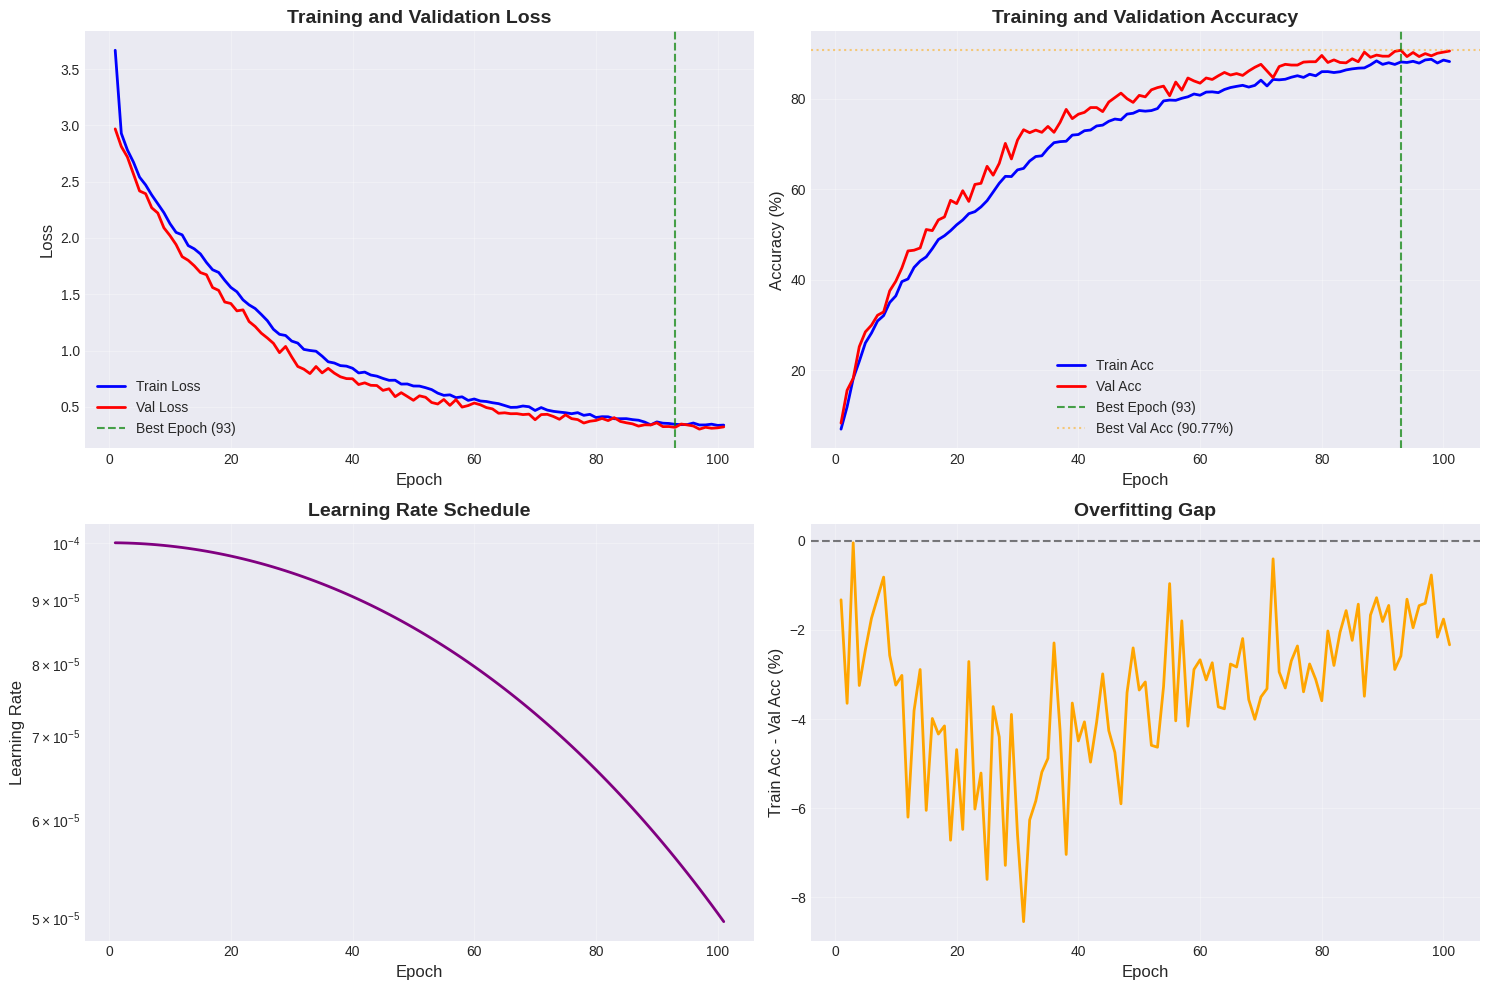


TRAINING SUMMARY

Training Configuration:
  ✓ Epochs trained: 101
  ✓ Best epoch: 93
  ✓ Training time: 84.88 minutes
  ✓ Time per epoch: 50.43 seconds

Final Performance:
  ✓ Best Val Accuracy: 90.77%
  ✓ Final Train Loss: 0.3390
  ✓ Final Val Loss: 0.3231
  ✓ Final Train Acc: 88.27%
  ✓ Final Val Acc: 90.60%
  
Overfitting Analysis:
  ✓ Final accuracy gap: -2.33%
  ✓ Best accuracy gap: -2.58%

Model Saved:
  ✓ Path: /kaggle/working/models/best_model.pth
  ✓ Validation accuracy: 90.77%

✓ Training history stored in train_config


In [12]:
# ============================================================================
# PART A: Training Configuration
# ============================================================================
print("=" * 80)
print("TRAINING CONFIGURATION")
print("=" * 80)

# Training hyperparameters
train_config = {
    'num_epochs': 200,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'lr_scheduler': 'cosine',  # Options: 'cosine', 'step', 'plateau'
    'patience': 8,            # For early stopping
    'gradient_clip': 1.0,      # Gradient clipping value
}

print(f"\nTraining Hyperparameters:")
print(f"  Epochs: {train_config['num_epochs']}")
print(f"  Learning rate: {train_config['learning_rate']}")
print(f"  Weight decay: {train_config['weight_decay']}")
print(f"  LR scheduler: {train_config['lr_scheduler']}")
print(f"  Early stopping patience: {train_config['patience']}")
print(f"  Gradient clipping: {train_config['gradient_clip']}")

# ============================================================================
# PART B: Loss Function for SNNs
# ============================================================================
print("\n" + "=" * 80)
print("LOSS FUNCTION DEFINITION")
print("=" * 80)

print("""
Loss Function Strategy:
  
For SNNs, we need to handle temporal spike outputs. We'll use a combination of:
1. Cross-entropy loss on spike counts (rate coding)
2. Membrane potential at final time step

We'll use the spike count approach where classification is based on
which neuron fires the most spikes over the entire time window.
""")

def snn_loss_function(spike_output, membrane_output, labels):
    """
    Loss function for spiking neural networks.
    
    Args:
        spike_output: (batch_size, num_steps, num_classes) - spike trains
        membrane_output: (batch_size, num_steps, num_classes) - membrane potentials
        labels: (batch_size,) - true class labels
    
    Returns:
        loss: Scalar loss value
    """
    # Method: Sum spikes over time to get spike counts per class
    # Shape: (batch_size, num_classes)
    spike_counts = spike_output.sum(dim=1)
    
    # Use cross-entropy loss on spike counts
    loss = F.cross_entropy(spike_counts, labels)
    
    return loss

print("✓ Loss function defined: Cross-entropy on spike counts")

# ============================================================================
# PART C: Optimizer and Scheduler
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZER & SCHEDULER CONFIGURATION")
print("=" * 80)

# Adam optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config['learning_rate'],
    weight_decay=train_config['weight_decay']
)

# Learning rate scheduler
if train_config['lr_scheduler'] == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=train_config['num_epochs'],
        eta_min=1e-6
    )
elif train_config['lr_scheduler'] == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=15,
        gamma=0.5
    )
elif train_config['lr_scheduler'] == 'plateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )
else:
    scheduler = None

print(f"✓ Optimizer: Adam")
print(f"  - Learning rate: {train_config['learning_rate']}")
print(f"  - Weight decay: {train_config['weight_decay']}")
print(f"✓ Scheduler: {train_config['lr_scheduler']}")

# ============================================================================
# PART D: Training & Validation Functions
# ============================================================================
print("\n" + "=" * 80)
print("DEFINING TRAINING FUNCTIONS")
print("=" * 80)

def train_one_epoch(model, train_loader, optimizer, device, epoch):
    """
    Train the model for one epoch.
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
    """
    model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]')
    
    for batch_idx, (inputs, labels) in enumerate(pbar):
        # Move to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        spike_output, membrane_output = model(inputs)
        
        # Compute loss
        loss = snn_loss_function(spike_output, membrane_output, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        if train_config['gradient_clip'] is not None:
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                train_config['gradient_clip']
            )
        
        # Optimizer step
        optimizer.step()
        
        # Calculate accuracy (based on spike counts)
        spike_counts = spike_output.sum(dim=1)  # Sum over time
        predictions = spike_counts.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

def validate(model, val_loader, device, epoch):
    """
    Validate the model.
    
    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy
    """
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} [Val]  ')
    
    with torch.no_grad():
        for inputs, labels in pbar:
            # Move to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            spike_output, membrane_output = model(inputs)
            
            # Compute loss
            loss = snn_loss_function(spike_output, membrane_output, labels)
            
            # Calculate accuracy
            spike_counts = spike_output.sum(dim=1)
            predictions = spike_counts.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

print("✓ Training functions defined")

# ============================================================================
# PART E: Training Loop with Early Stopping
# ============================================================================
print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)

# Initialize tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0

print(f"\nTraining for {train_config['num_epochs']} epochs...")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Device: {device}\n")

# Start training timer
training_start = time.time()

for epoch in range(train_config['num_epochs']):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, epoch)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, device, epoch)
    
    # Update learning rate
    if scheduler is not None:
        if train_config['lr_scheduler'] == 'plateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()
    
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{train_config['num_epochs']} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")
    
    # Check for best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, MODEL_DIR / 'best_model.pth')
        
        print(f"  ✓ New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{train_config['patience']}")
    
    # Early stopping
    if patience_counter >= train_config['patience']:
        print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
        break
    
    print("-" * 80)

training_time = time.time() - training_start

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"\nTotal training time: {training_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")

# ============================================================================
# PART F: Plot Training History
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZING TRAINING HISTORY")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Validation Loss
ax1 = axes[0, 0]
epochs_range = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
ax2 = axes[0, 1]
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
ax2.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax2.axhline(y=best_val_acc, color='orange', linestyle=':', alpha=0.5, label=f'Best Val Acc ({best_val_acc:.2f}%)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
ax3 = axes[1, 0]
ax3.plot(epochs_range, history['lr'], 'purple', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Accuracy Gap (Overfitting indicator)
ax4 = axes[1, 1]
acc_gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
ax4.plot(epochs_range, acc_gap, 'orange', linewidth=2)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Train Acc - Val Acc (%)', fontsize=12)
ax4.set_title('Overfitting Gap', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
print("✓ Saved: training_history.png")
plt.show()

# ============================================================================
# PART G: Training Summary
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING SUMMARY")
print("=" * 80)

summary = f"""
Training Configuration:
  ✓ Epochs trained: {len(history['train_loss'])}
  ✓ Best epoch: {best_epoch}
  ✓ Training time: {training_time/60:.2f} minutes
  ✓ Time per epoch: {training_time/len(history['train_loss']):.2f} seconds

Final Performance:
  ✓ Best Val Accuracy: {best_val_acc:.2f}%
  ✓ Final Train Loss: {history['train_loss'][-1]:.4f}
  ✓ Final Val Loss: {history['val_loss'][-1]:.4f}
  ✓ Final Train Acc: {history['train_acc'][-1]:.2f}%
  ✓ Final Val Acc: {history['val_acc'][-1]:.2f}%
  
Overfitting Analysis:
  ✓ Final accuracy gap: {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%
  ✓ Best accuracy gap: {history['train_acc'][best_epoch-1] - best_val_acc:.2f}%

Model Saved:
  ✓ Path: {MODEL_DIR / 'best_model.pth'}
  ✓ Validation accuracy: {best_val_acc:.2f}%
"""

print(summary)

# Store training history for later analysis
train_config['history'] = history
train_config['best_val_acc'] = best_val_acc
train_config['best_epoch'] = best_epoch
print("✓ Training history stored in train_config")

## 🔍 Step 7: Test Set Evaluation & Comprehensive Analysis

---

### ⚙️ Objective

Conduct a **final, in-depth performance assessment** of the trained spiking neural network on the unseen test set, quantifying generalization, diagnosing failure modes, and visualizing temporal behavior.

---

### 📊 Evaluation Pipeline Components

The analysis framework includes the following key elements:

* **Model checkpoint loading** — loads the best-performing model weights saved during training
* **Aggregate performance metrics** — calculates final **test accuracy** and **loss**
* **Confusion matrix analysis** — visualizes per-class prediction patterns and misclassifications
* **Detailed classification report** — computes **precision, recall, and F1-score** for each class
* **Inference visualization** — generates **spike raster plots** and membrane potential traces to inspect temporal dynamics
* **Error analysis** — identifies systematic failure cases and challenging input patterns

---

This setup ensures:

* A rigorous and unbiased final model assessment
* Actionable insights into model strengths and weaknesses
* Clear visualization of both statistical performance and spiking behavior
* A foundation for model iteration and improvement

LOADING BEST MODEL FOR EVALUATION
✓ Loaded best model from epoch 93
  Validation accuracy: 90.77%
  Validation loss: 0.3189

EVALUATING ON TEST SET

Evaluating 36 batches...


Testing:   0%|          | 0/36 [00:00<?, ?it/s]


TEST SET RESULTS

Test Loss: 1.0501
Test Accuracy: 72.31%
Correct predictions: 1637/2264

CONFUSION MATRIX ANALYSIS
✓ Saved: confusion_matrix.png


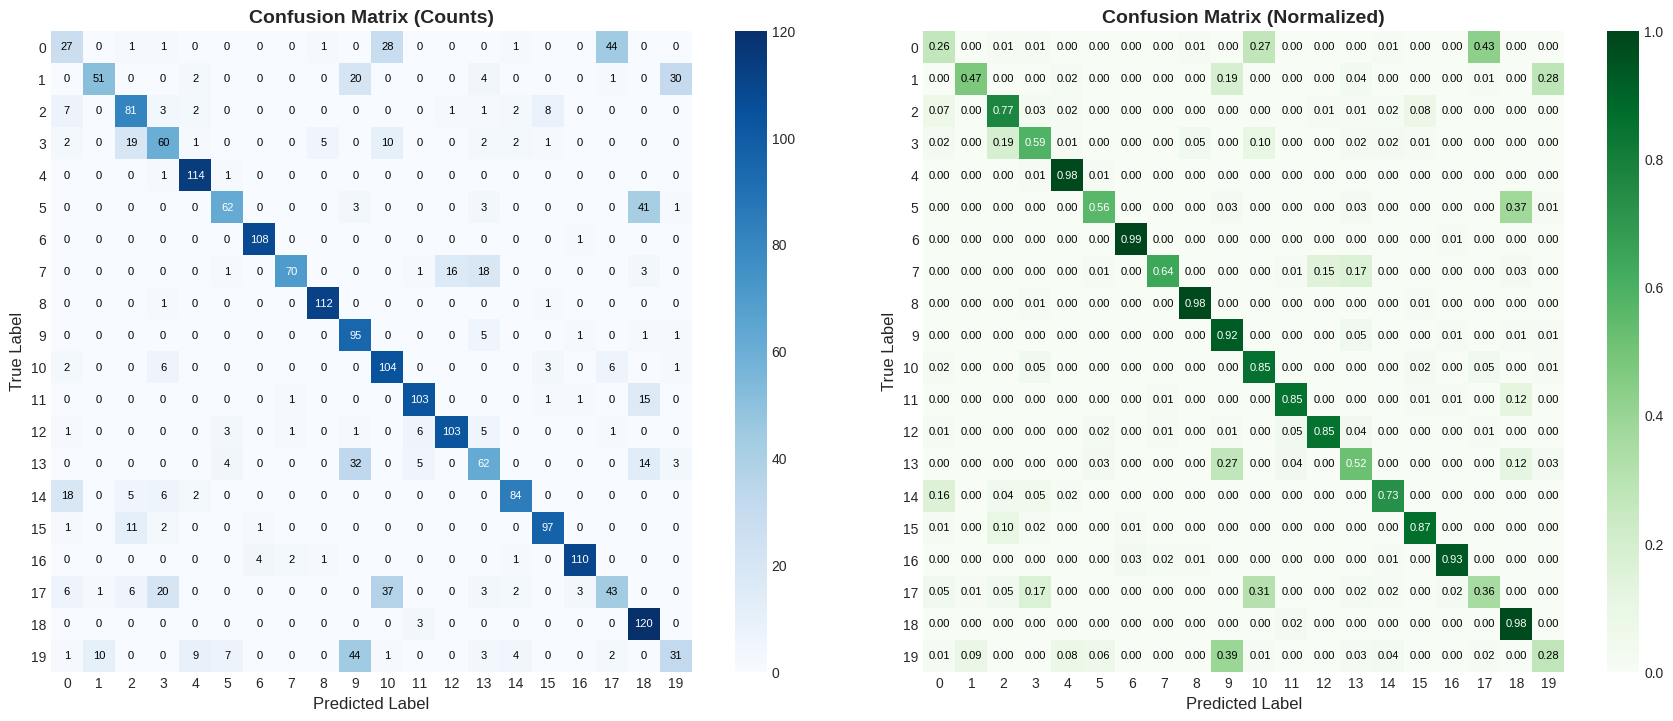


PER-CLASS PERFORMANCE METRICS

Per-Class Metrics:
              precision  recall  f1-score   support
Class 0           0.415   0.262     0.321   103.000
Class 1           0.823   0.472     0.600   108.000
Class 2           0.659   0.771     0.711   105.000
Class 3           0.600   0.588     0.594   102.000
Class 4           0.877   0.983     0.927   116.000
Class 5           0.795   0.564     0.660   110.000
Class 6           0.956   0.991     0.973   109.000
Class 7           0.946   0.642     0.765   109.000
Class 8           0.941   0.982     0.961   114.000
Class 9           0.487   0.922     0.638   103.000
Class 10          0.578   0.852     0.689   122.000
Class 11          0.873   0.851     0.862   121.000
Class 12          0.858   0.851     0.855   121.000
Class 13          0.585   0.517     0.549   120.000
Class 14          0.875   0.730     0.796   115.000
Class 15          0.874   0.866     0.870   112.000
Class 16          0.948   0.932     0.940   118.000
Class 17     

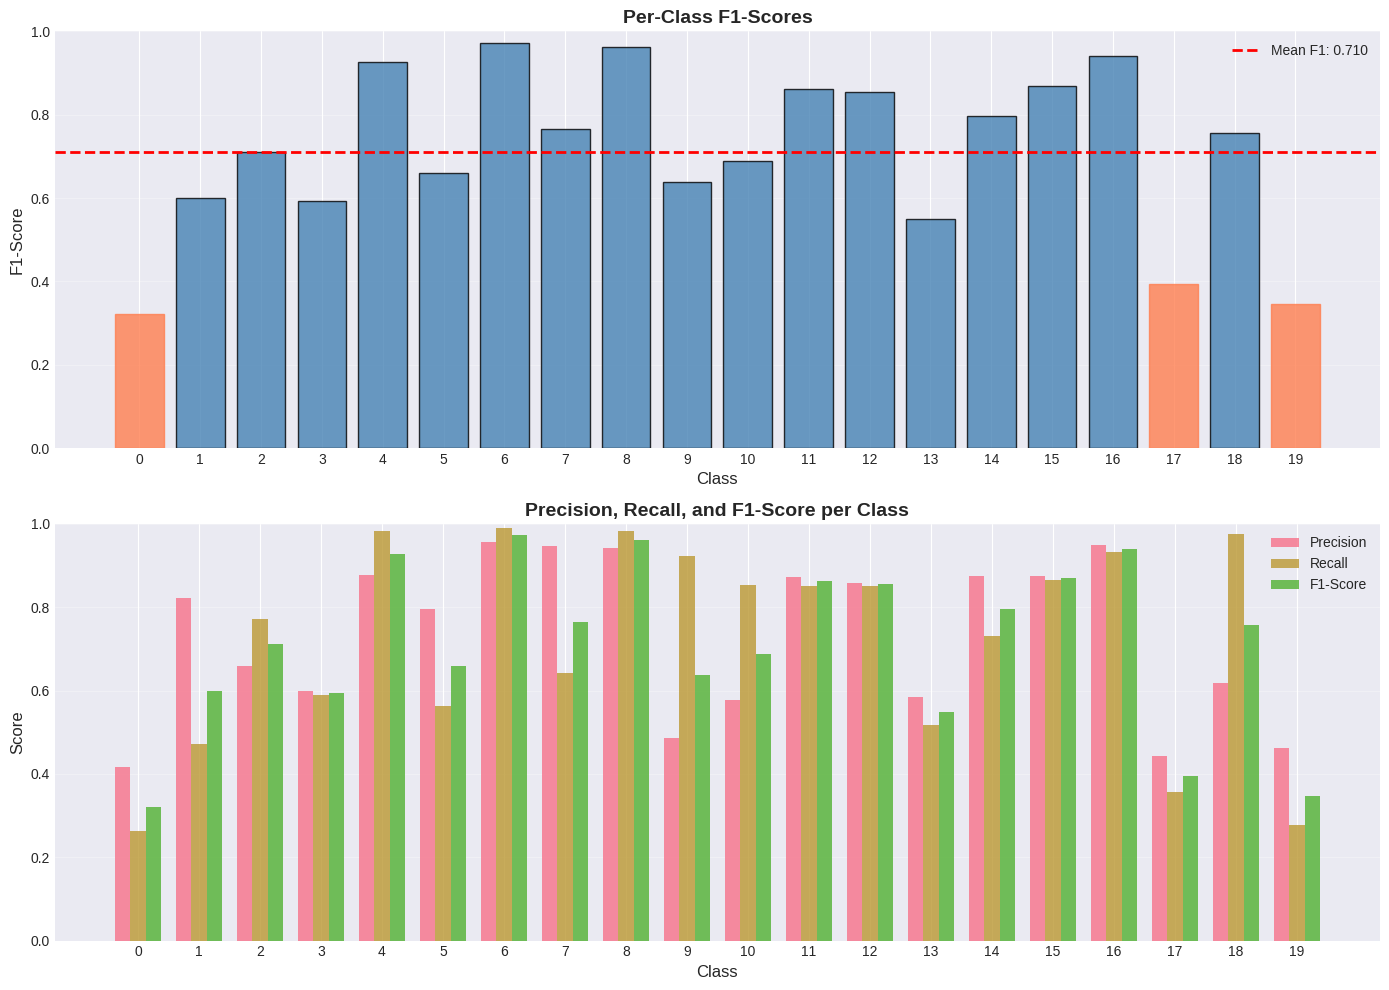


Best Performing Classes:
  1. Class 6: F1=0.973, Precision=0.956, Recall=0.991
  2. Class 8: F1=0.961, Precision=0.941, Recall=0.982
  3. Class 16: F1=0.940, Precision=0.948, Recall=0.932

Worst Performing Classes:
  1. Class 0: F1=0.321, Precision=0.415, Recall=0.262
  2. Class 19: F1=0.346, Precision=0.463, Recall=0.277
  3. Class 17: F1=0.394, Precision=0.443, Recall=0.355

SPIKE COUNT ANALYSIS

Spike Count Statistics:
  Mean spike count: 6.27
  Std spike count: 7.43
  Min spike count: 0.00
  Max spike count: 67.00
✓ Saved: spike_count_analysis.png


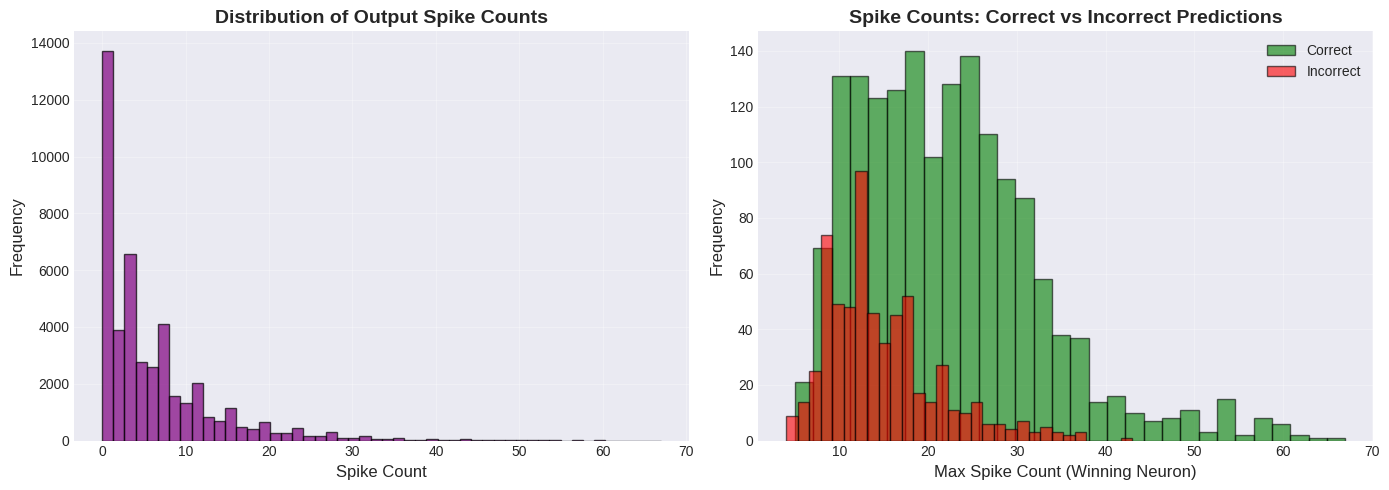


VISUALIZING SAMPLE PREDICTIONS
✓ Saved: inference_visualization.png


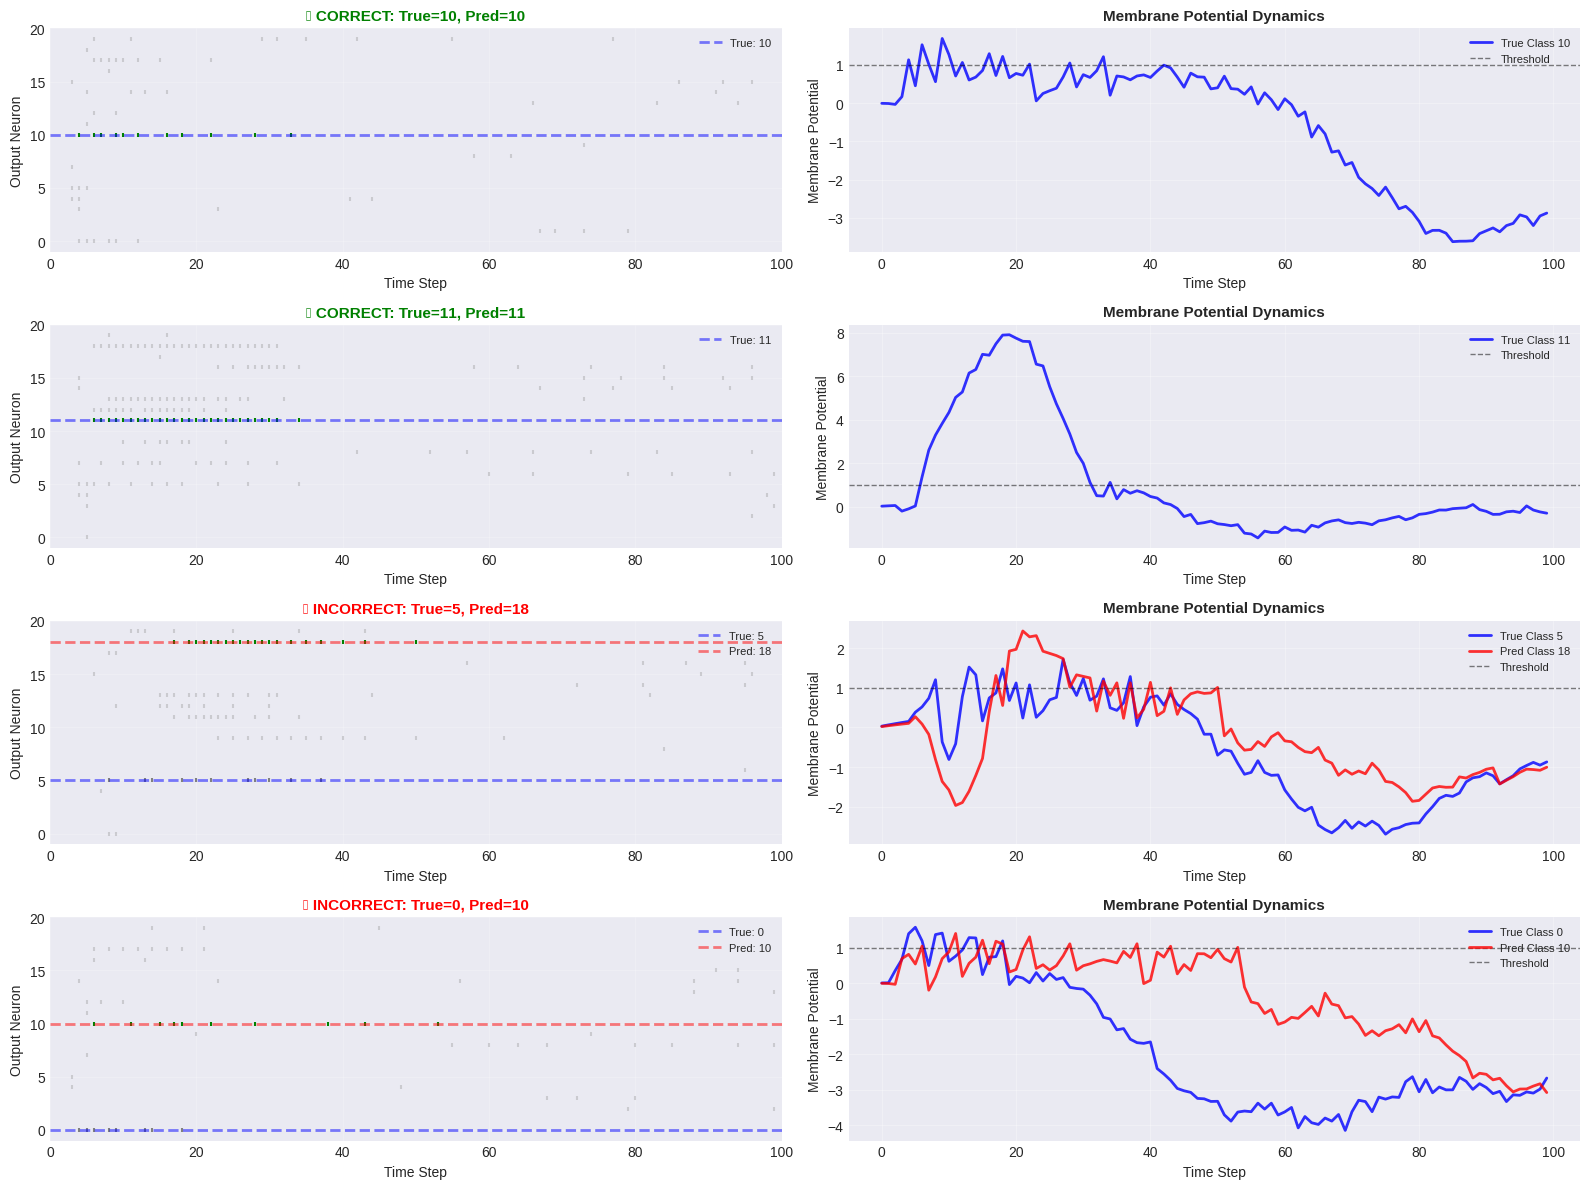


EVALUATION COMPLETE ✓

Test Set Evaluation Summary:

Overall Performance:
  ✓ Test Accuracy: 72.31%
  ✓ Test Loss: 1.0501
  ✓ Total samples: 2264
  ✓ Correct predictions: 1637
  ✓ Incorrect predictions: 627

Average Metrics:
  ✓ Macro Precision: 0.731
  ✓ Macro Recall: 0.719
  ✓ Macro F1-Score: 0.710
  ✓ Weighted F1-Score: 0.713

Spike Statistics:
  ✓ Mean output spikes: 6.27
  ✓ Std output spikes: 7.43
  ✓ Spike count range: [0, 67]

Best Performing Class: 6 (F1: 0.973)
Worst Performing Class: 0 (F1: 0.321)

Visualizations Saved:
  ✓ confusion_matrix.png
  ✓ per_class_metrics.png
  ✓ spike_count_analysis.png
  ✓ inference_visualization.png

All outputs saved to: /kaggle/working/outputs

✓ Evaluation results saved to evaluation_results.npy


In [13]:
# ============================================================================
# PART A: Load Best Model
# ============================================================================
print("=" * 80)
print("LOADING BEST MODEL FOR EVALUATION")
print("=" * 80)

# Load the best model checkpoint
checkpoint_path = MODEL_DIR / 'best_model.pth'

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from epoch {checkpoint['epoch'] + 1}")
    print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  Validation loss: {checkpoint['val_loss']:.4f}")
else:
    print("⚠ No checkpoint found, using current model state")

model.to(device)
model.eval()

# ============================================================================
# PART B: Test Set Evaluation
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATING ON TEST SET")
print("=" * 80)

def evaluate_test_set(model, test_loader, device):
    """
    Comprehensive test set evaluation.
    
    Returns:
        test_loss: Average test loss
        test_acc: Test accuracy
        all_predictions: All predicted labels
        all_labels: All true labels
        all_spike_counts: Spike counts for all samples
    """
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0
    
    all_predictions = []
    all_labels = []
    all_spike_counts = []
    
    print(f"\nEvaluating {len(test_loader)} batches...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            # Move to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            spike_output, membrane_output = model(inputs)
            
            # Compute loss
            loss = snn_loss_function(spike_output, membrane_output, labels)
            
            # Calculate predictions
            spike_counts = spike_output.sum(dim=1)  # (batch_size, num_classes)
            predictions = spike_counts.argmax(dim=1)
            
            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_spike_counts.extend(spike_counts.cpu().numpy())
            
            # Accumulate metrics
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
    
    test_loss = total_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    
    return test_loss, test_acc, np.array(all_predictions), np.array(all_labels), np.array(all_spike_counts)

# Run evaluation
test_loss, test_acc, predictions, true_labels, spike_counts = evaluate_test_set(model, test_loader, device)

print(f"\n" + "=" * 80)
print("TEST SET RESULTS")
print("=" * 80)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Correct predictions: {(predictions == true_labels).sum()}/{len(true_labels)}")

# ============================================================================
# PART C: Confusion Matrix
# ============================================================================
print("\n" + "=" * 80)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 80)

from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
ax1 = axes[0]
im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
plt.colorbar(im1, ax=ax1)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

ax1.set_xticks(np.arange(20))
ax1.set_yticks(np.arange(20))
ax1.grid(False)

# Plot 2: Normalized
ax2 = axes[1]
im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap='Greens', vmin=0, vmax=1)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
plt.colorbar(im2, ax=ax2)

# Add text annotations
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax2.text(j, i, format(cm_normalized[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > 0.5 else "black",
                fontsize=8)

ax2.set_xticks(np.arange(20))
ax2.set_yticks(np.arange(20))
ax2.grid(False)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png")
plt.show()

# ============================================================================
# PART D: Per-Class Metrics
# ============================================================================
print("\n" + "=" * 80)
print("PER-CLASS PERFORMANCE METRICS")
print("=" * 80)

# Generate classification report
class_report = classification_report(
    true_labels, 
    predictions,
    target_names=[f'Class {i}' for i in range(20)],
    output_dict=True
)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(class_report).transpose()

# Display per-class metrics
print("\nPer-Class Metrics:")
print(report_df.round(3))

# Visualize per-class accuracy
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Per-class F1 scores
ax1 = axes[0]
classes = list(range(20))
f1_scores = [class_report[f'Class {i}']['f1-score'] for i in classes]

bars = ax1.bar(classes, f1_scores, color='steelblue', edgecolor='black', alpha=0.8)
ax1.axhline(y=np.mean(f1_scores), color='red', linestyle='--', 
           linewidth=2, label=f'Mean F1: {np.mean(f1_scores):.3f}')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_title('Per-Class F1-Scores', fontsize=14, fontweight='bold')
ax1.set_xticks(classes)
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Highlight worst performing classes
worst_classes = np.argsort(f1_scores)[:3]
for idx in worst_classes:
    bars[idx].set_color('coral')

# Plot 2: Precision, Recall, F1 comparison
ax2 = axes[1]
metrics_data = {
    'Precision': [class_report[f'Class {i}']['precision'] for i in classes],
    'Recall': [class_report[f'Class {i}']['recall'] for i in classes],
    'F1-Score': [class_report[f'Class {i}']['f1-score'] for i in classes]
}

x = np.arange(len(classes))
width = 0.25

bars1 = ax2.bar(x - width, metrics_data['Precision'], width, label='Precision', alpha=0.8)
bars2 = ax2.bar(x, metrics_data['Recall'], width, label='Recall', alpha=0.8)
bars3 = ax2.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score', alpha=0.8)

ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Precision, Recall, and F1-Score per Class', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'per_class_metrics.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: per_class_metrics.png")
plt.show()

# Identify best and worst performing classes
print("\nBest Performing Classes:")
best_classes = np.argsort(f1_scores)[-3:][::-1]
for rank, cls in enumerate(best_classes, 1):
    print(f"  {rank}. Class {cls}: F1={f1_scores[cls]:.3f}, "
          f"Precision={class_report[f'Class {cls}']['precision']:.3f}, "
          f"Recall={class_report[f'Class {cls}']['recall']:.3f}")

print("\nWorst Performing Classes:")
worst_classes = np.argsort(f1_scores)[:3]
for rank, cls in enumerate(worst_classes, 1):
    print(f"  {rank}. Class {cls}: F1={f1_scores[cls]:.3f}, "
          f"Precision={class_report[f'Class {cls}']['precision']:.3f}, "
          f"Recall={class_report[f'Class {cls}']['recall']:.3f}")

# ============================================================================
# PART E: Spike Count Analysis
# ============================================================================
print("\n" + "=" * 80)
print("SPIKE COUNT ANALYSIS")
print("=" * 80)

# Analyze spike count distributions
print("\nSpike Count Statistics:")
print(f"  Mean spike count: {spike_counts.mean():.2f}")
print(f"  Std spike count: {spike_counts.std():.2f}")
print(f"  Min spike count: {spike_counts.min():.2f}")
print(f"  Max spike count: {spike_counts.max():.2f}")

# Plot spike count distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall spike count distribution
ax1 = axes[0]
ax1.hist(spike_counts.flatten(), bins=50, color='purple', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Spike Count', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Output Spike Counts', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Spike counts for correct vs incorrect predictions
ax2 = axes[1]
correct_mask = predictions == true_labels
max_spike_counts_correct = spike_counts[correct_mask].max(axis=1)
max_spike_counts_incorrect = spike_counts[~correct_mask].max(axis=1)

ax2.hist(max_spike_counts_correct, bins=30, alpha=0.6, label='Correct', color='green', edgecolor='black')
ax2.hist(max_spike_counts_incorrect, bins=30, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
ax2.set_xlabel('Max Spike Count (Winning Neuron)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Spike Counts: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spike_count_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved: spike_count_analysis.png")
plt.show()

# ============================================================================
# PART F: Inference Visualization (Sample Predictions)
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZING SAMPLE PREDICTIONS")
print("=" * 80)

def visualize_inference(model, test_loader, device, num_samples=4):
    """
    Visualize model predictions with spike rasters and membrane potentials.
    """
    model.eval()
    
    # Get a batch
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward pass
    with torch.no_grad():
        spike_output, membrane_output = model(inputs)
    
    # Get predictions
    spike_counts = spike_output.sum(dim=1)
    predictions = spike_counts.argmax(dim=1)
    
    # Select samples (2 correct, 2 incorrect)
    correct_indices = torch.where(predictions == labels)[0][:2]
    incorrect_indices = torch.where(predictions != labels)[0][:2]
    
    if len(incorrect_indices) == 0:
        sample_indices = correct_indices[:num_samples]
    else:
        sample_indices = torch.cat([correct_indices, incorrect_indices])[:num_samples]
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 3*num_samples))
    
    for idx, sample_idx in enumerate(sample_indices):
        sample_idx = sample_idx.item()
        
        # Get data
        sample_spikes = spike_output[sample_idx].cpu().numpy()  # (time_steps, num_classes)
        sample_mem = membrane_output[sample_idx].cpu().numpy()
        true_label = labels[sample_idx].item()
        pred_label = predictions[sample_idx].item()
        is_correct = true_label == pred_label
        
        # Plot spike raster
        ax_spikes = axes[idx, 0]
        for neuron in range(sample_spikes.shape[1]):
            spike_times = np.where(sample_spikes[:, neuron] > 0)[0]
            color = 'green' if neuron == pred_label else 'gray'
            alpha = 1.0 if neuron == pred_label or neuron == true_label else 0.3
            ax_spikes.scatter(spike_times, [neuron] * len(spike_times),
                            s=10, c=color, alpha=alpha, marker='|')
        
        # Highlight true and predicted classes
        ax_spikes.axhline(y=true_label, color='blue', linestyle='--', 
                         linewidth=2, alpha=0.5, label=f'True: {true_label}')
        if not is_correct:
            ax_spikes.axhline(y=pred_label, color='red', linestyle='--',
                             linewidth=2, alpha=0.5, label=f'Pred: {pred_label}')
        
        ax_spikes.set_ylabel('Output Neuron', fontsize=10)
        ax_spikes.set_xlabel('Time Step', fontsize=10)
        ax_spikes.set_xlim(0, sample_spikes.shape[0])
        ax_spikes.set_ylim(-1, sample_spikes.shape[1])
        title_color = 'green' if is_correct else 'red'
        status = '✓ CORRECT' if is_correct else '✗ INCORRECT'
        ax_spikes.set_title(f'{status}: True={true_label}, Pred={pred_label}',
                           fontsize=11, fontweight='bold', color=title_color)
        ax_spikes.legend(loc='upper right', fontsize=8)
        ax_spikes.grid(True, alpha=0.2)
        
        # Plot membrane potentials for true and predicted neurons
        ax_mem = axes[idx, 1]
        ax_mem.plot(sample_mem[:, true_label], 'b-', linewidth=2, 
                   label=f'True Class {true_label}', alpha=0.8)
        if not is_correct:
            ax_mem.plot(sample_mem[:, pred_label], 'r-', linewidth=2,
                       label=f'Pred Class {pred_label}', alpha=0.8)
        ax_mem.axhline(y=1.0, color='black', linestyle='--', 
                      linewidth=1, alpha=0.5, label='Threshold')
        ax_mem.set_xlabel('Time Step', fontsize=10)
        ax_mem.set_ylabel('Membrane Potential', fontsize=10)
        ax_mem.set_title('Membrane Potential Dynamics', fontsize=11, fontweight='bold')
        ax_mem.legend(loc='upper right', fontsize=8)
        ax_mem.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'inference_visualization.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: inference_visualization.png")
    plt.show()

visualize_inference(model, test_loader, device, num_samples=4)

# ============================================================================
# PART G: Final Evaluation Summary
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATION COMPLETE ✓")
print("=" * 80)

summary = f"""
Test Set Evaluation Summary:

Overall Performance:
  ✓ Test Accuracy: {test_acc:.2f}%
  ✓ Test Loss: {test_loss:.4f}
  ✓ Total samples: {len(true_labels)}
  ✓ Correct predictions: {(predictions == true_labels).sum()}
  ✓ Incorrect predictions: {(predictions != true_labels).sum()}

Average Metrics:
  ✓ Macro Precision: {class_report['macro avg']['precision']:.3f}
  ✓ Macro Recall: {class_report['macro avg']['recall']:.3f}
  ✓ Macro F1-Score: {class_report['macro avg']['f1-score']:.3f}
  ✓ Weighted F1-Score: {class_report['weighted avg']['f1-score']:.3f}

Spike Statistics:
  ✓ Mean output spikes: {spike_counts.mean():.2f}
  ✓ Std output spikes: {spike_counts.std():.2f}
  ✓ Spike count range: [{spike_counts.min():.0f}, {spike_counts.max():.0f}]

Best Performing Class: {best_classes[0]} (F1: {f1_scores[best_classes[0]]:.3f})
Worst Performing Class: {worst_classes[0]} (F1: {f1_scores[worst_classes[0]]:.3f})

Visualizations Saved:
  ✓ confusion_matrix.png
  ✓ per_class_metrics.png
  ✓ spike_count_analysis.png
  ✓ inference_visualization.png

All outputs saved to: {OUTPUT_DIR}
"""

print(summary)

# Save evaluation results
eval_results = {
    'test_acc': test_acc,
    'test_loss': test_loss,
    'predictions': predictions,
    'true_labels': true_labels,
    'confusion_matrix': cm,
    'classification_report': class_report,
    'spike_counts': spike_counts
}

# Save to disk
np.save(OUTPUT_DIR / 'evaluation_results.npy', eval_results)
print("✓ Evaluation results saved to evaluation_results.npy")